<a href="https://colab.research.google.com/github/Karasiari/Graphs/blob/main/MCFwith.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

Устанавливаем класс под алгоритм

In [2]:
%pip install "git+https://github.com/Karasiari/graphmcf.git"

  Cloning https://github.com/Karasiari/graphmcf.git to /tmp/pip-req-build-8a48mngg
  Running command git clone --filter=blob:none --quiet https://github.com/Karasiari/graphmcf.git /tmp/pip-req-build-8a48mngg
  Resolved https://github.com/Karasiari/graphmcf.git to commit dd6c92c250f30941942559be6340885a645a2958
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for graphmcf: filename=graphmcf-0.1.0-py3-none-any.whl size=36243 sha256=ff607d75f73e9ab3ac4ee0eaca652ab5a4bb5a8448b2c48ef1968f95f1fcf141
  Stored in directory: /tmp/pip-ephem-wheel-cache-4zljnuzr/wheels/e2/0b/c2/f959f38e6d22c15057366b9e17b9295eb9dfc85fd11eff7962
Successfully built graphmcf


Функции для решения MCF - дополнительная проверка наших результатов

In [3]:
import numpy as np

import cvxpy as cp
import networkx as nx

from dataclasses import dataclass
from typing import Optional

@dataclass(frozen=True)
class Solution:
    problem: cp.Problem
    flow: np.ndarray
    add_bandwidth: Optional[np.ndarray] = None
    gamma: Optional[float] = None
    traffic_mat: Optional[float] = None

    def to_vector(self) -> np.ndarray:
        sol_parts = [self.flow.T.flatten()]
        if self.add_bandwidth is not None:
            sol_parts.append(self.add_bandwidth)
        if self.gamma is not None:
            sol_parts.append(self.gamma)
        return np.hstack(sol_parts)


def vector_to_solution(graph: nx.DiGraph, vec: np.ndarray, problem_type: str):
    m, n = graph.number_of_edges(), graph.number_of_nodes()
    flow = vec[: m * n].reshape(n, m).T
    add_bandwidth = None
    gamma = None
    if problem_type in ["opt_network_min_cost_concurrent_flow", "opt_network_max_concurrent_flow"]:
        add_bandwidth = vec[m * n : m * n + m]
    if problem_type in ["max_concurrent_flow", "opt_network_max_concurrent_flow"]:
        gamma = vec[-1]
    return Solution(problem=None, flow=flow, add_bandwidth=add_bandwidth, gamma=gamma)

# Вспомогательные

def get_incidence_matrix(graph: nx.DiGraph) -> np.ndarray:
    """
    Construct incidence matrix
    :param graph: nx.DiGraph,: graph with attribute cost on edges
    :return:
        incidence_matrix: ndarray of shape (num_nodes, num_edges), incidence matrix
    """
    incidence_matrix = nx.incidence_matrix(graph, edgelist=graph.edges, oriented=True)
    incidence_matrix = incidence_matrix.toarray()
    return incidence_matrix

def get_weights(graph: nx.DiGraph) -> np.ndarray:
    """
    Extract edge weights
    :param graph: nx.DiGraph, graph with weights on edges
    :param key: str, name of attribute to obtain weights
    :return:
        weights: ndarray of shape (num_nodes), all edge weights in graph
    """
    edges_with_weights = [(edge, data['weight']) for edge, data in graph.edges.items()]
    edges_with_weights_dict = {key: value for key, value in edges_with_weights}
    return np.array(list(edges_with_weights_dict.values()), dtype=np.float64)

def get_var_value(var: Optional[cp.Variable]) -> Optional[float | np.ndarray]:
    """
    Get cvxpy.Variable value if not None
    :param var: cvxpy.Variable, variable to extract value
    :return:
        value: var.value if var is not None, else None
    """
    return var.value if var is not None else None


# Решение

def solve_throughput(graph: nx.Graph, traffic_lapl: np.ndarray, **solver_kwargs) -> Solution:
    graph = nx.DiGraph(graph)
    incidence_mat = get_incidence_matrix(graph)
    bandwidth = get_weights(graph)

    flow = cp.Variable((len(graph.edges), traffic_lapl.shape[0]))
    gamma = cp.Variable()
    prob = cp.Problem(
        cp.Maximize(gamma),
        [cp.sum(flow, axis=1) <= bandwidth, incidence_mat @ flow == -gamma * traffic_lapl.T, flow >= 0, gamma >= 0],
    )
    prob.solve(**solver_kwargs)

    if prob.status != "optimal":
        gamma = None

    return Solution(problem=prob, flow=get_var_value(flow), gamma=get_var_value(gamma))

Для чтения наших графов - неориентированные, мультребра просуммированы в одно

In [4]:
import pandas as pd
import numpy as np
import os # Выберите, откуда тяните папку
from google.colab import files

BITRATE_DENOMINATOR = 100

# По папке формируем словарь графов со структурой -
#                                                {'название графа (как в папке)':
#                                                       {'adj_matrix': матрица смежности взвешенного графа - веса capacity,
#                                                        'traffic_matrix': матрица корреспонденций,
#                                                        'nodes_params': {'degrees': список степеней вершин,
#                                                                         'source_demands': список суммарного входящего траффика,
#                                                                         'target_demands': список суммарного исходящего траффика,
#                                                                         'sum_demands': список усредненного траффика (source + target) / 2
#                                                                        }
#                                                       }
#                                                }

def csv_to_graph(path, demands_path, capacity_path):
  Df = pd.read_csv(path, header=None, names = ['id', 'source', 'target', 'length'])
  Traffic = pd.read_csv(demands_path, header=None, names = ['id', 'source', 'target', 'bitrate'])
  Capacity = pd.read_csv(capacity_path, header=None, names = ['name', 'value'])
  df = Df.iloc[1:].copy()
  traffic = Traffic.iloc[1:].copy()
  capacity = Capacity.iloc[1:].copy()
  df['source'] = df['source'].astype(int)
  df['target'] = df['target'].astype(int)
  #df['length'] = df['length'].astype(float)
  traffic['source'] = traffic['source'].astype(int)
  traffic['target'] = traffic['target'].astype(int)
  traffic['bitrate'] = traffic['bitrate'].astype(int) // BITRATE_DENOMINATOR
  traffic_grouped = traffic.groupby(['source', 'target']).sum().reset_index()
  capacity_value = (float(capacity[capacity['name']=='LineRate']['value']) // BITRATE_DENOMINATOR) * int(capacity[capacity['name']=='NumberOfWavelengths']['value'])

  sources = df['source'].tolist()
  targets = df['target'].tolist()
  lengths = df['length'].tolist()

  unique_vertices = set()
  for source, target in zip(sources, targets):
    unique_vertices.add(source)
    unique_vertices.add(target)
  vertex_mapping = {old: new for new, old in enumerate(unique_vertices)}
  num_vertices = len(unique_vertices)

  adj_matrix = np.zeros((num_vertices, num_vertices))
  traffic_matrix = np.zeros((num_vertices, num_vertices))

  for source, target, length in zip(sources, targets, lengths):
    new_source = vertex_mapping[source]
    new_target = vertex_mapping[target]
    #adj_matrix[new_source, new_target] = length
    #adj_matrix[new_target, new_source] = length
    adj_matrix[new_source, new_target] = capacity_value
    adj_matrix[new_target, new_source] = capacity_value

  traffic_grouped['source'] = traffic_grouped['source'].map(vertex_mapping)
  traffic_grouped['target'] = traffic_grouped['target'].map(vertex_mapping)
  for _, row in traffic_grouped.iterrows():
    traffic_matrix[row['source'], row['target']] = row['bitrate']

  nodes_params = {}

  degrees = list(np.count_nonzero(adj_matrix, axis=1).astype(np.float64))
  nodes_params['degrees'] = degrees

  source_demands = list(np.sum(traffic_matrix, axis=1))
  nodes_params['source_demands'] = source_demands

  target_demands = list(np.sum(traffic_matrix, axis=0))
  nodes_params['target_demands'] = target_demands

  sum_demands = [(i + j)/2 for (i,j) in zip(source_demands, target_demands)]
  nodes_params['sum_demands'] = sum_demands

  return (adj_matrix, traffic_matrix, nodes_params)

def get_graphs(base_path, specified_graphs, specified):
  Graphs = {}
  csv_tables = []
  for folder_name in os.listdir(base_path):
    if folder_name in specified_graphs or not specified:
      folder_path = os.path.join(base_path, folder_name)
      csv_path = os.path.join(folder_path, 'links.csv')
      csv_path_demands = os.path.join(folder_path, 'demands.csv')
      csv_path_capacity = os.path.join(folder_path, 'params.csv')
      csv_tables.append(folder_name)

      (adj_matrix, traffic_matrix, nodes_params) = csv_to_graph(csv_path, csv_path_demands, csv_path_capacity)
      Graphs[folder_name] = {'adj_matrix': adj_matrix, 'traffic_matrix': traffic_matrix, 'nodes_params': nodes_params}

  return Graphs

path_to_folder = '/content/drive/MyDrive/Кола' # Свой путь

Протестируем на выборке cola графов - маленькие (<100 вершин)

In [5]:
small_graphs_for_test_names = ['cola_t3', 'cola_t10', 'cola_t2', 'cola_t8']
small_graphs_for_test = get_graphs(path_to_folder, small_graphs_for_test_names, True)

====================================   Анализ работы алгоритма для cola_t10  ====================================
=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 1.09 c
Итераций: 183 (доля от максимума 8300 = 2.20%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.2097, final_alpha=0.2265, converged=True
Плохие шаги всего: 94 (доля 0.52)
  — adversarial-плохих: 94 (доля 0.52)
  — friendly-плохих:   0 (доля 0.00)


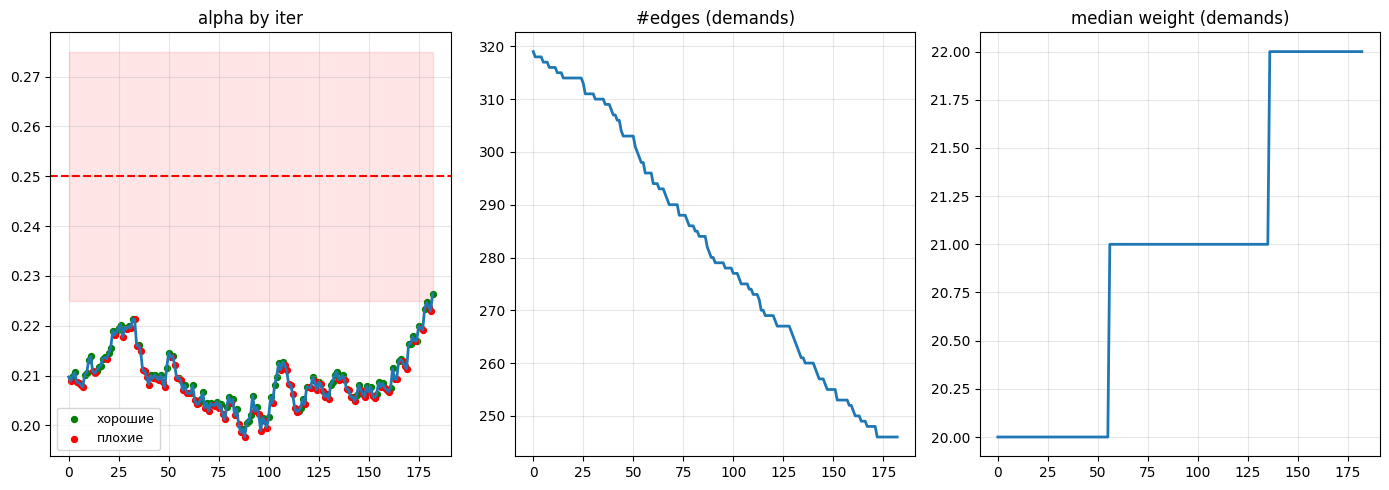

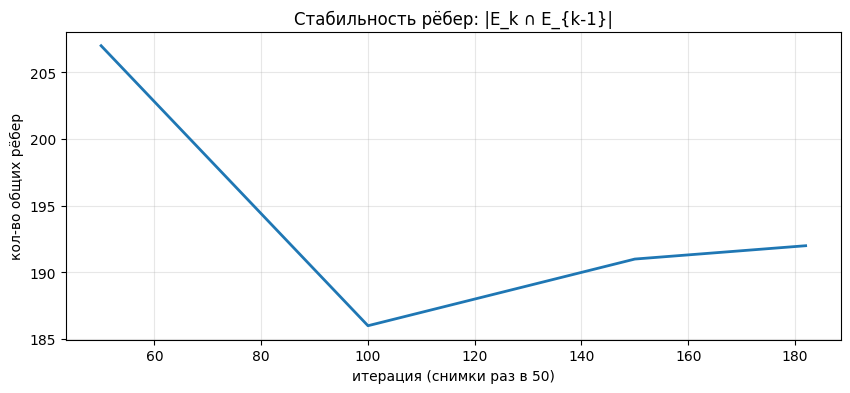

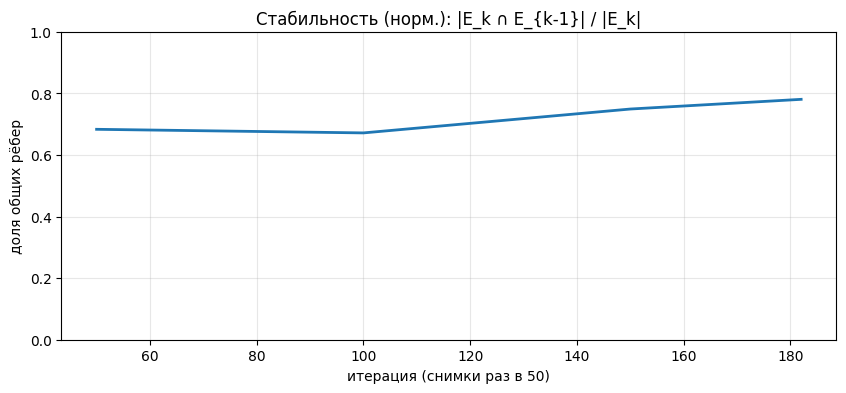

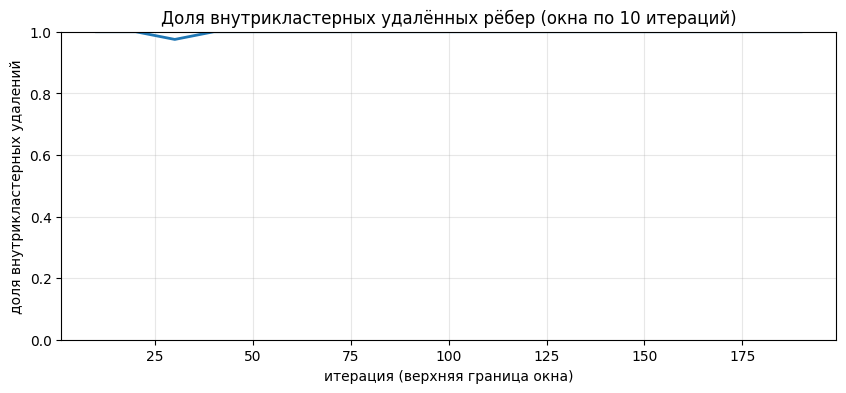

 метрика  initial  final
   edges      319    246
median_w       20     22
  mean_w       20     27
   sum_w     6413   6671


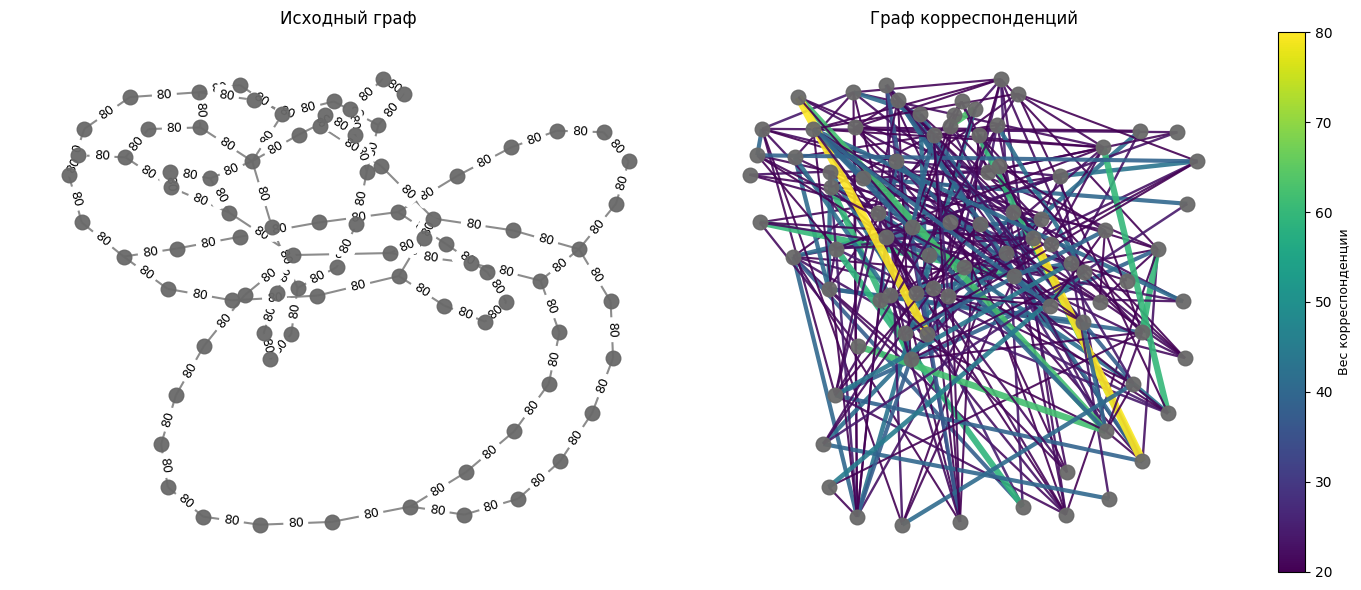

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 12.04 c
Итераций: 2032 (доля от максимума 8300 = 24.48%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.2165, final_alpha=0.4796, converged=True
Плохие шаги всего: 989 (доля 0.49)
  — adversarial-плохих: 989 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


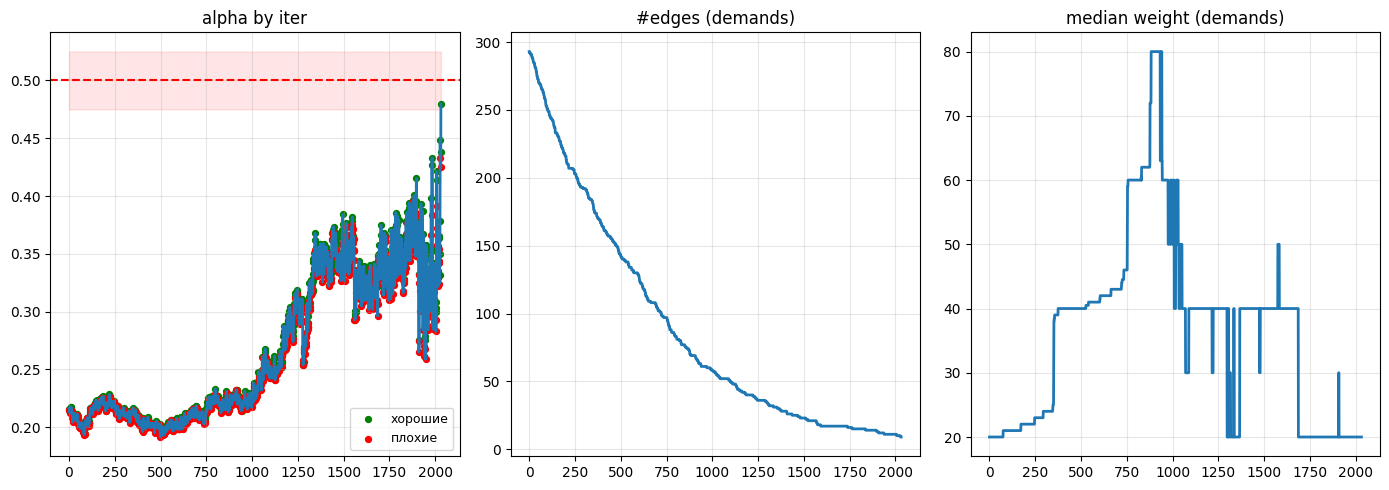

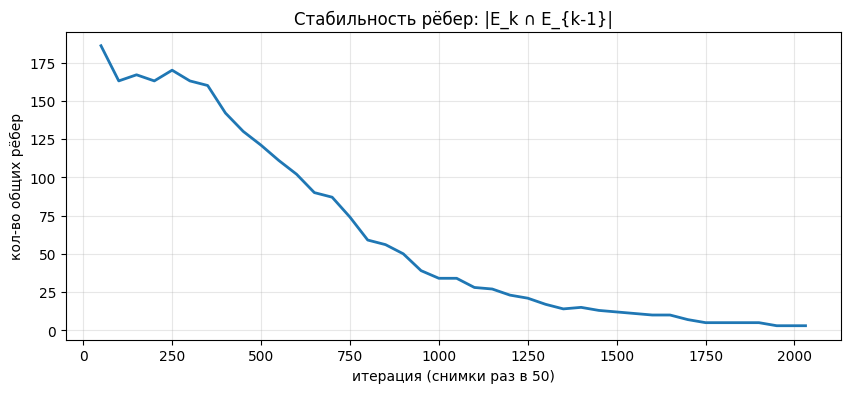

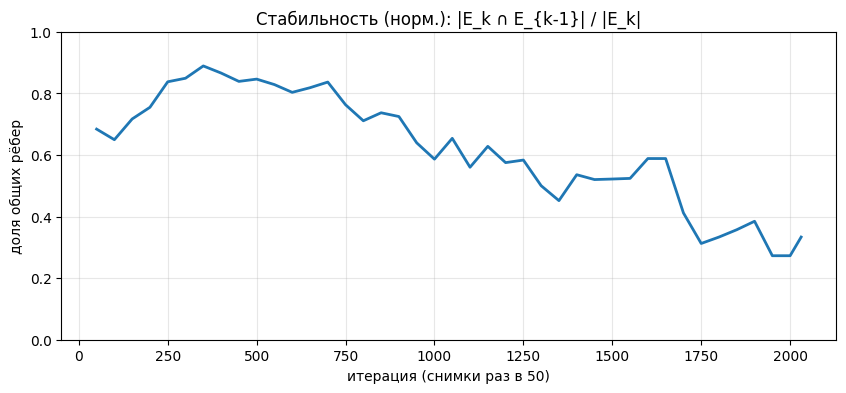

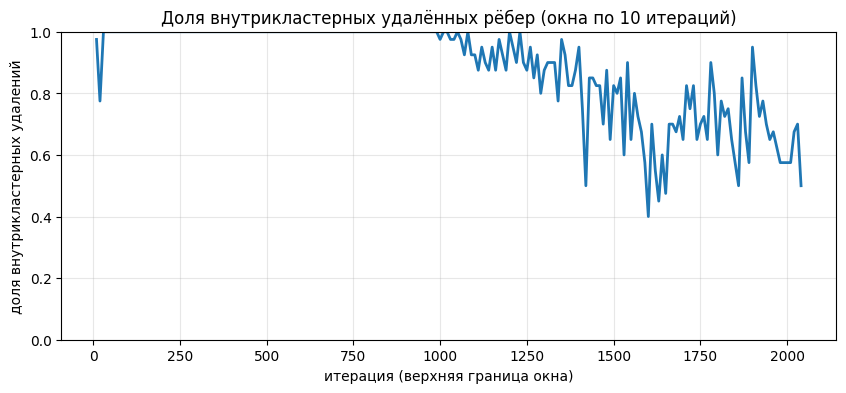

 метрика  initial  final
   edges      293      9
median_w       20     20
  mean_w       20     42
   sum_w     5858    380


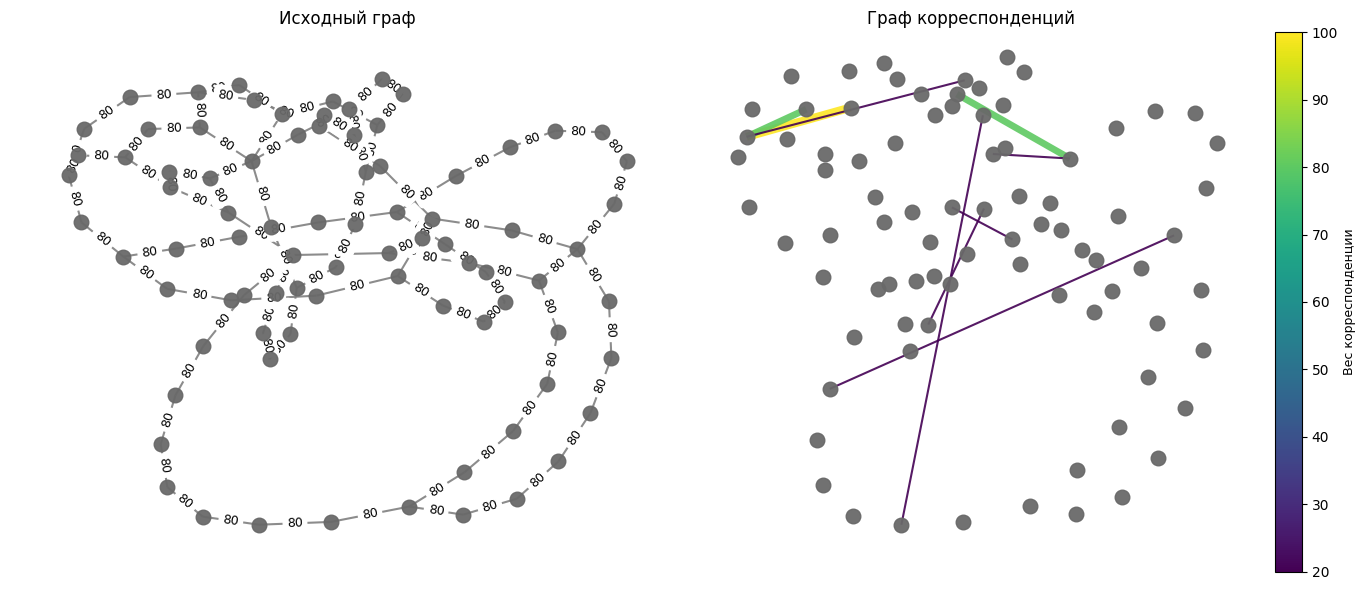

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 16.16 c
Итераций: 3104 (доля от максимума 8300 = 37.40%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.2187, final_alpha=0.7442, converged=True
Плохие шаги всего: 1490 (доля 0.48)
  — adversarial-плохих: 1490 (доля 0.48)
  — friendly-плохих:   0 (доля 0.00)


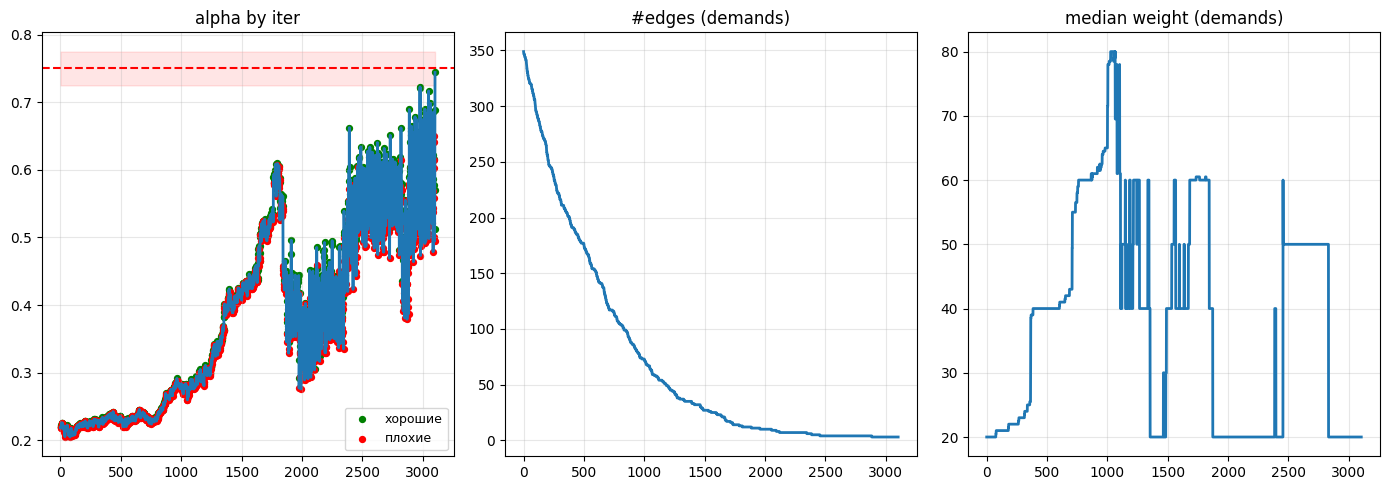

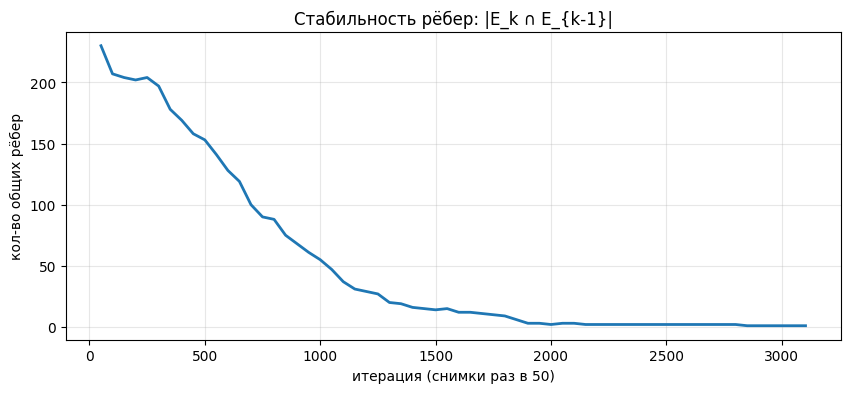

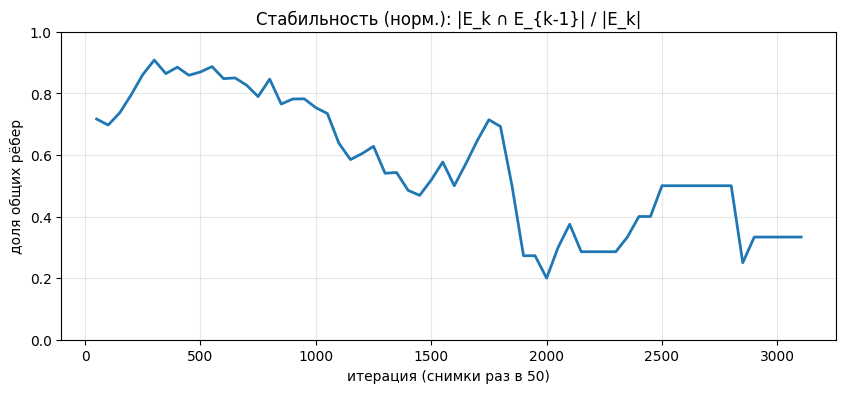

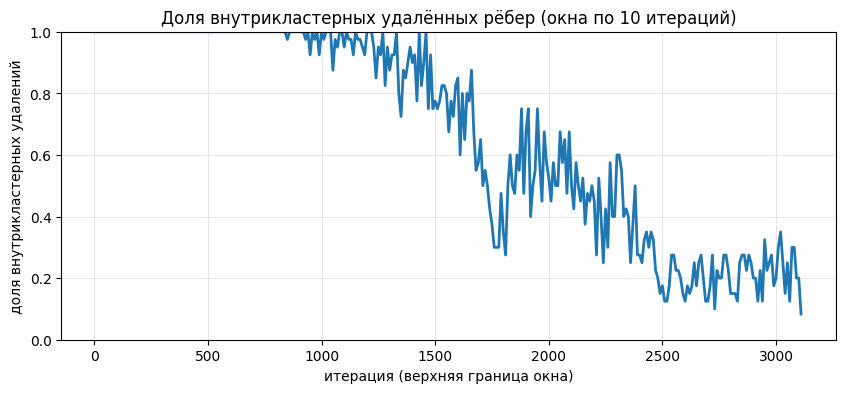

 метрика  initial  final
   edges      349      3
median_w       20     20
  mean_w       20     47
   sum_w     6905    141


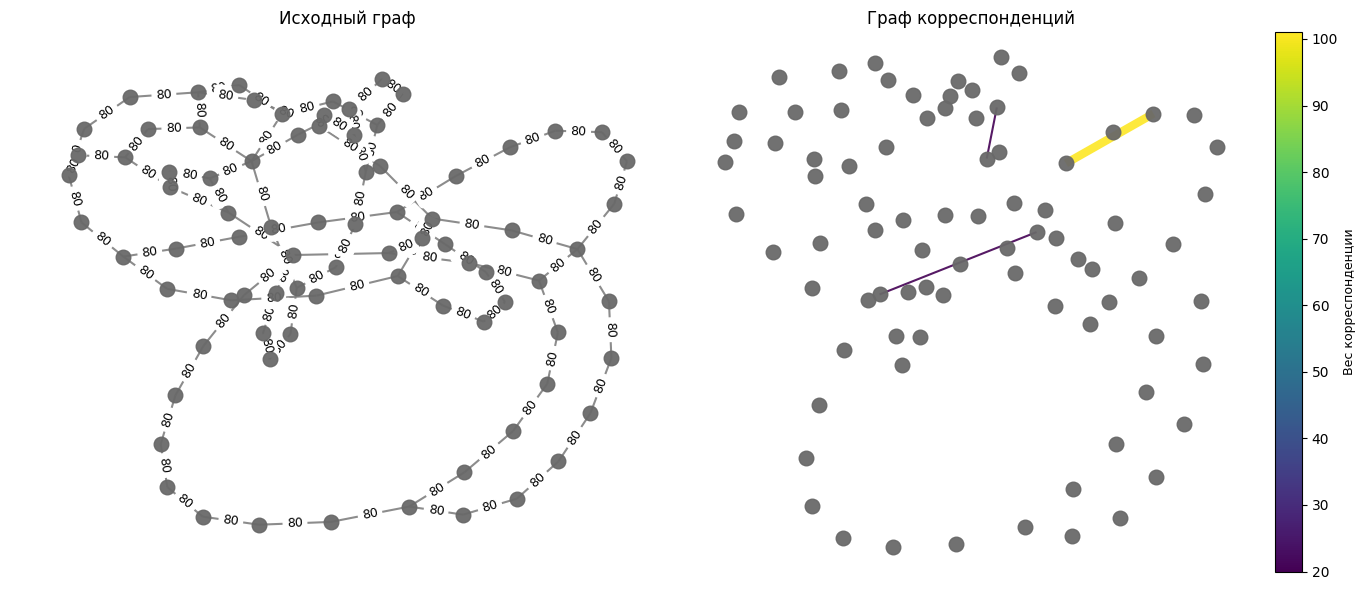



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 0.088 alpha_target=0.5: 0.800 alpha_target=0.75: 1.584
Средняя загруженность ребер: alpha_target=0.25: 0.851 alpha_target=0.5: 0.048 alpha_target=0.75: 0.018


=================================== Конец анализа работы алгоритма для cola_t10 ===================================


====================================   Анализ работы алгоритма для cola_t3  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.01 c
Итераций: 1 (доля от максимума 2100 = 0.05%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.2729, final_alpha=0.2729, converged=True
Плохие шаги всего: 0 (доля 0.00)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   0 (доля 0.00)


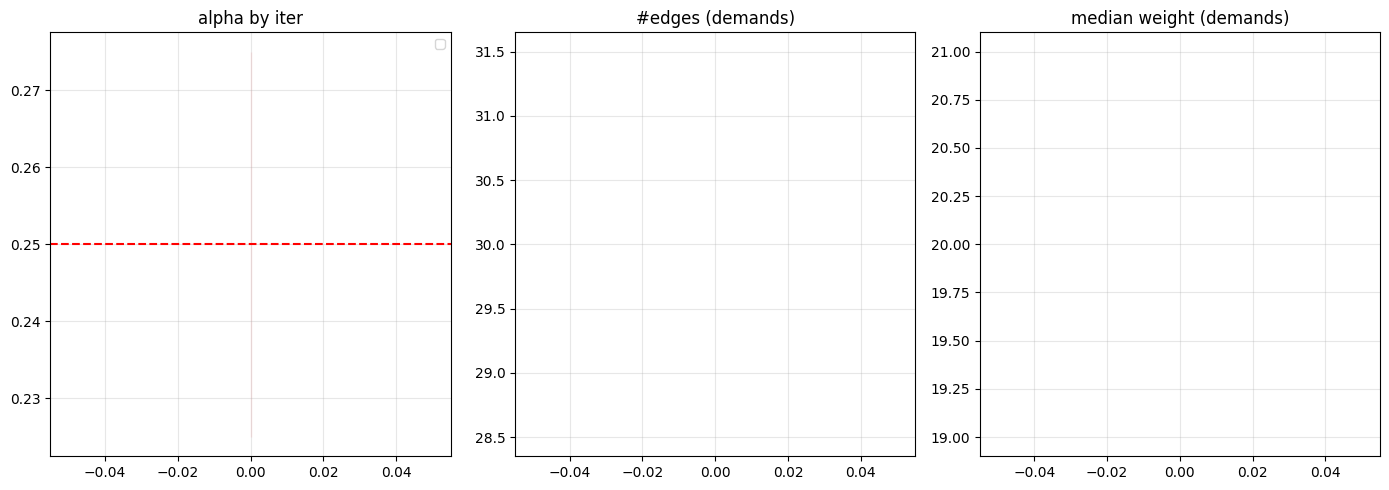

 метрика  initial  final
   edges       30     30
median_w       20     20
  mean_w       20     20
   sum_w      598    598


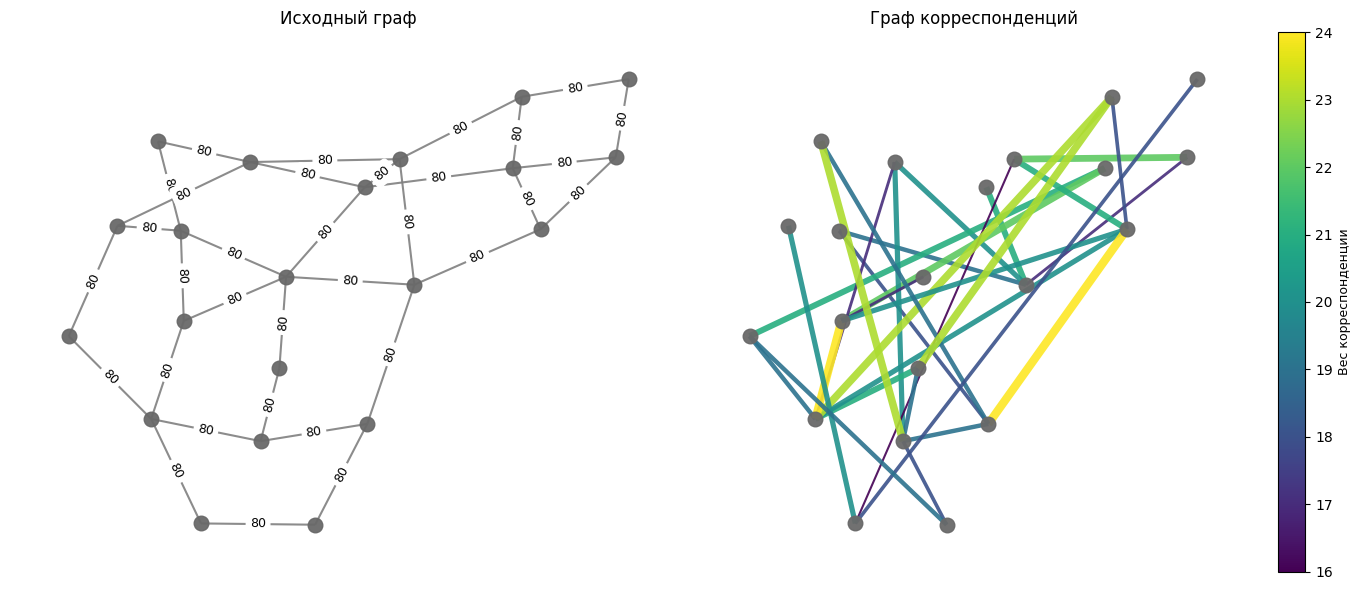

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.17 c
Итераций: 54 (доля от максимума 2100 = 2.57%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.2356, final_alpha=0.5167, converged=True
Плохие шаги всего: 24 (доля 0.45)
  — adversarial-плохих: 24 (доля 0.45)
  — friendly-плохих:   0 (доля 0.00)


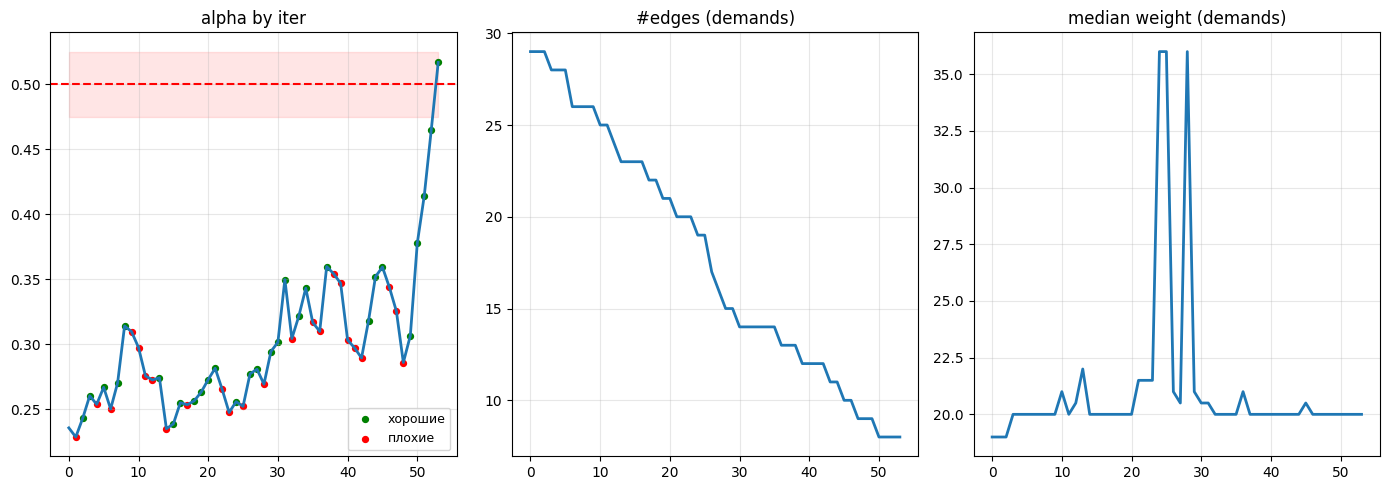

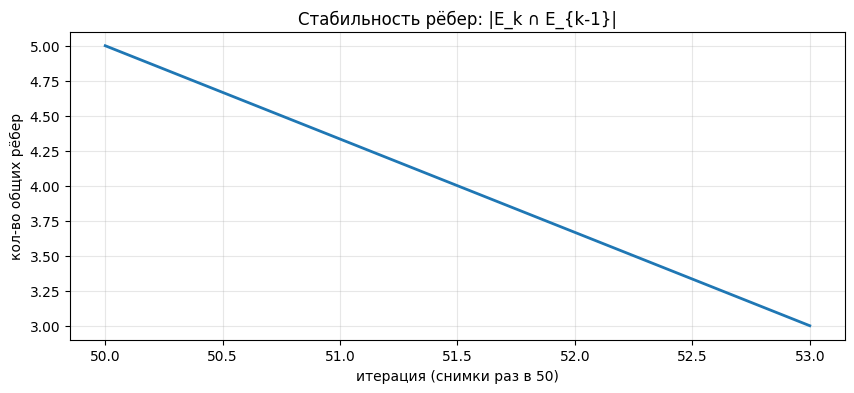

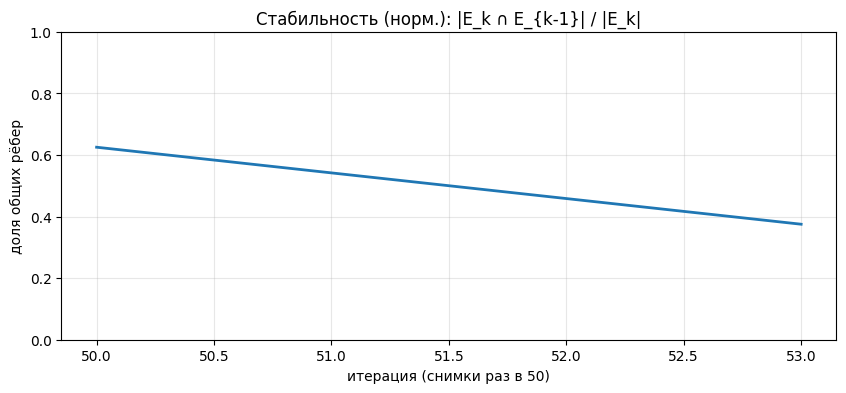

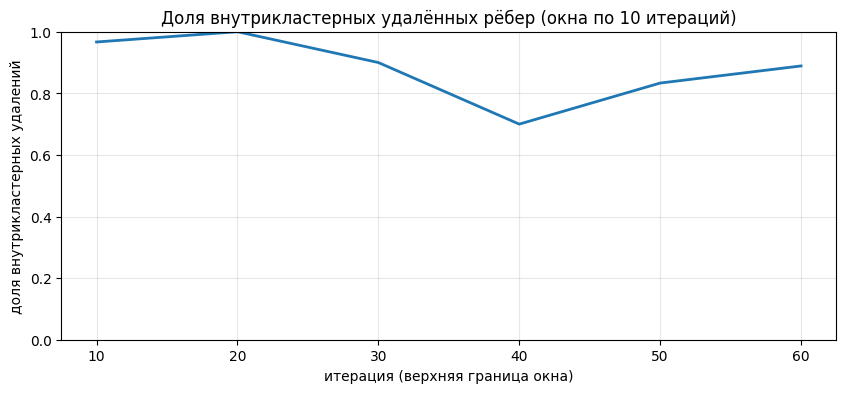

 метрика  initial  final
   edges       29      8
median_w       19     20
  mean_w       20     28
   sum_w      580    220


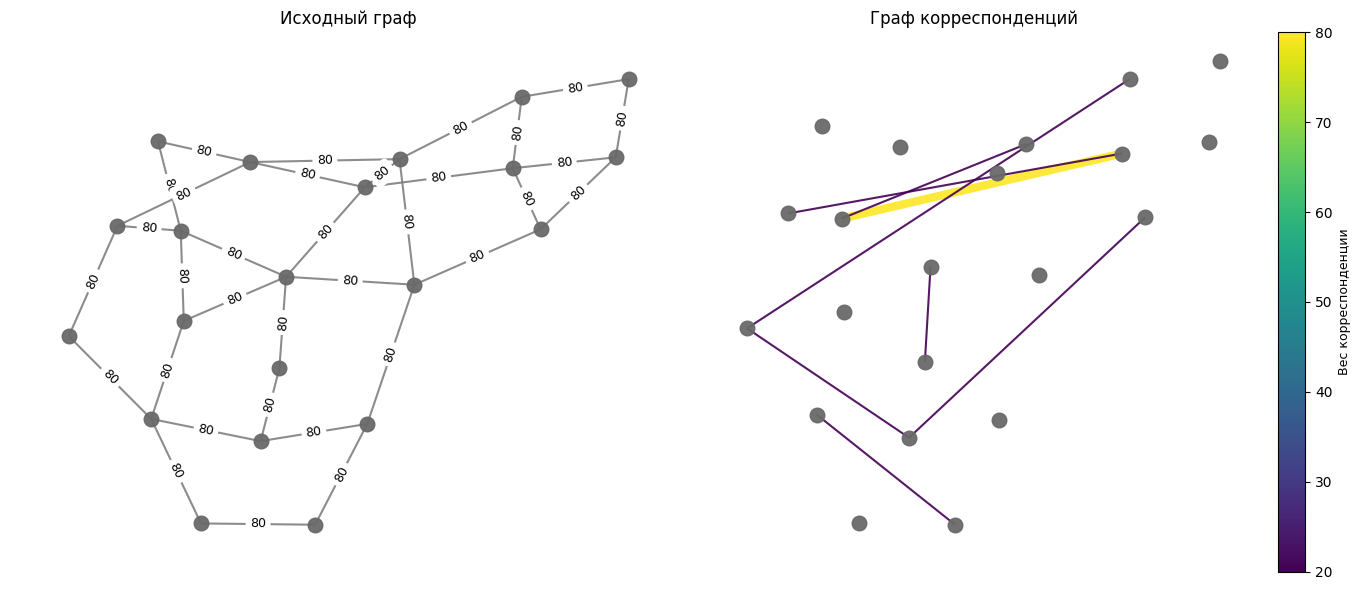

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.28 c
Итераций: 115 (доля от максимума 2100 = 5.48%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.3002, final_alpha=0.7467, converged=True
Плохие шаги всего: 57 (доля 0.50)
  — adversarial-плохих: 57 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


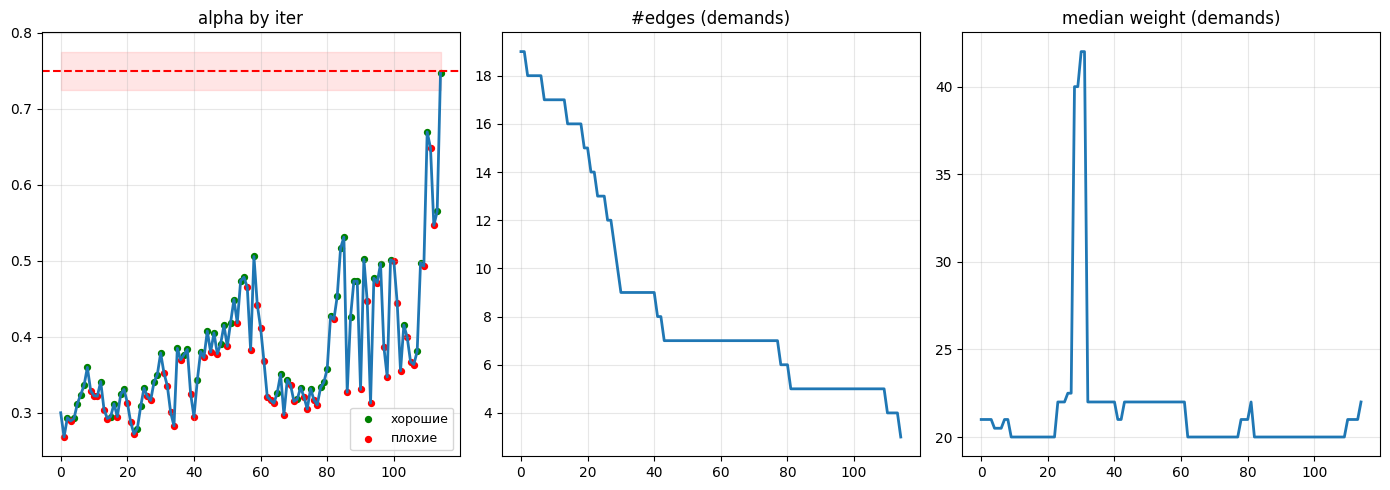

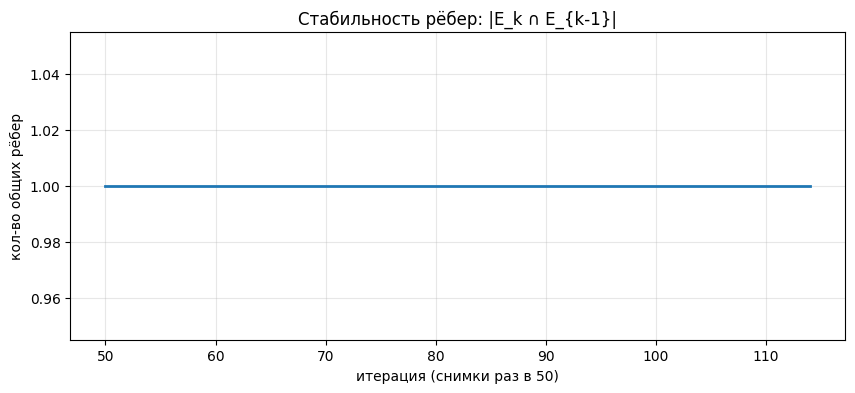

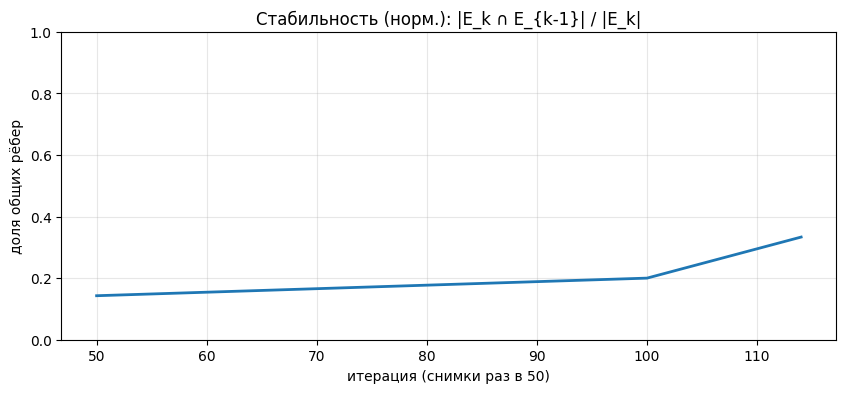

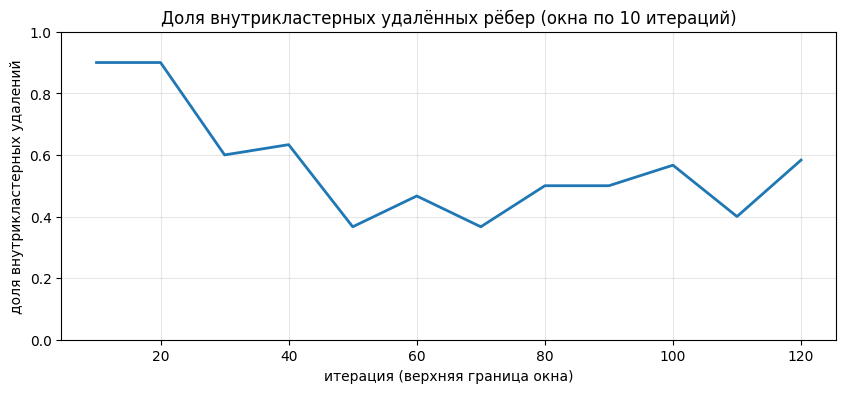

 метрика  initial  final
   edges       19      3
median_w       21     22
  mean_w       20     34
   sum_w      384    102


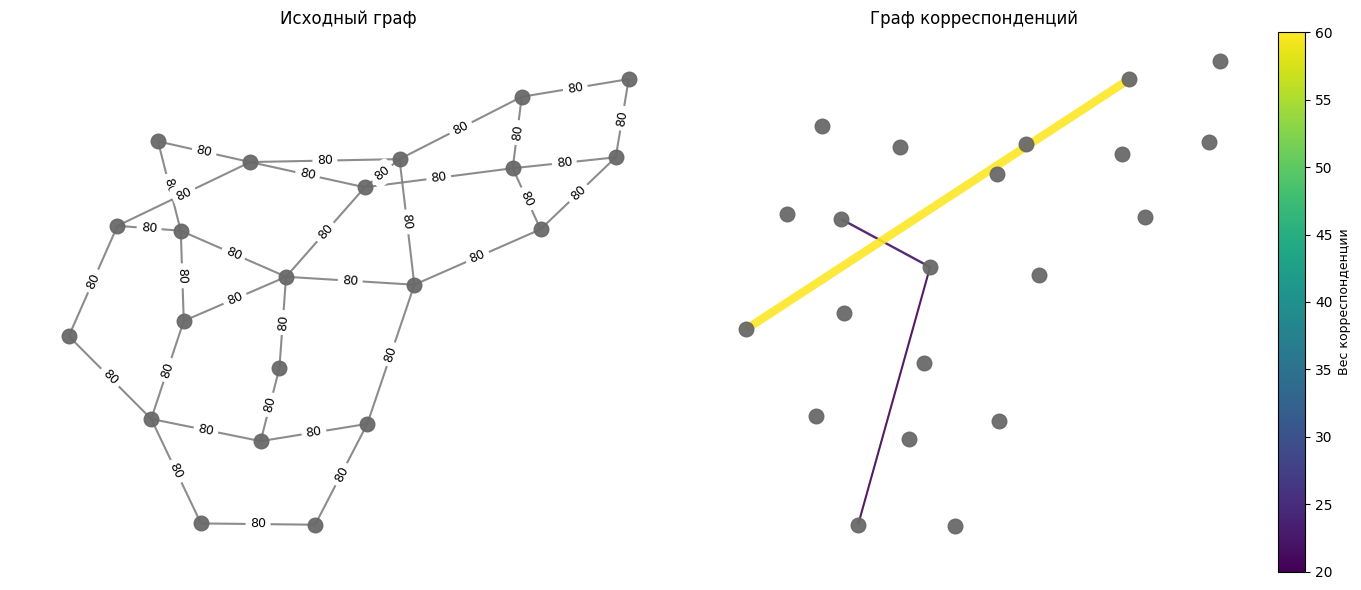



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 1.000 alpha_target=0.5: 1.714 alpha_target=0.75: 2.667
Средняя загруженность ребер: alpha_target=0.25: 0.227 alpha_target=0.5: 0.083 alpha_target=0.75: 0.039


=================================== Конец анализа работы алгоритма для cola_t3 ===================================


====================================   Анализ работы алгоритма для cola_t8  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 2.73 c
Итераций: 719 (доля от максимума 5400 = 13.31%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.3341, final_alpha=0.2737, converged=True
Плохие шаги всего: 372 (доля 0.52)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   372 (доля 0.52)


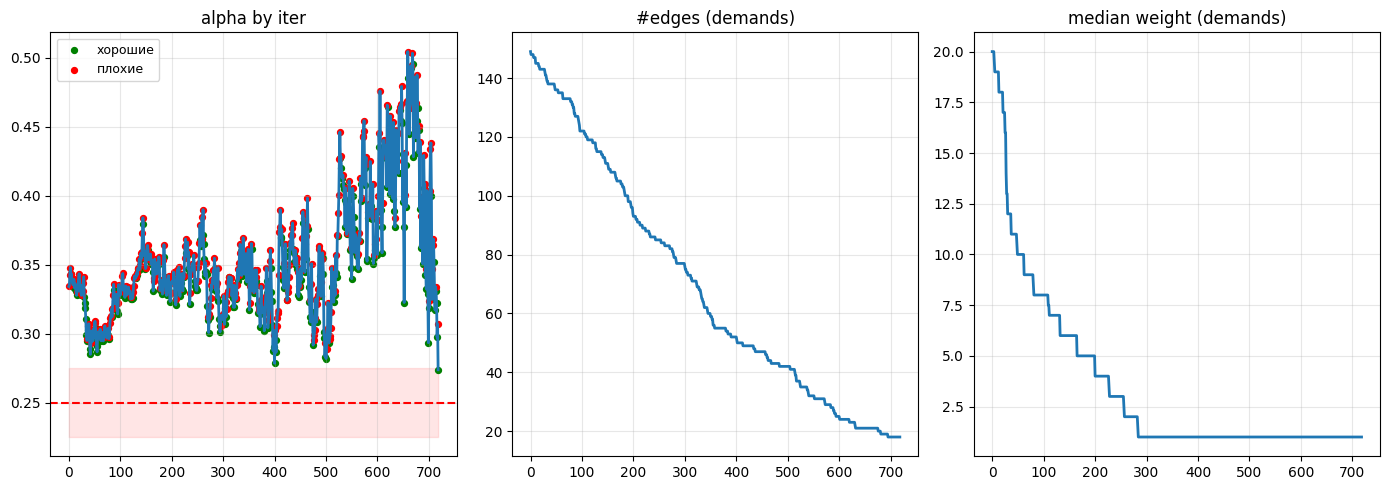

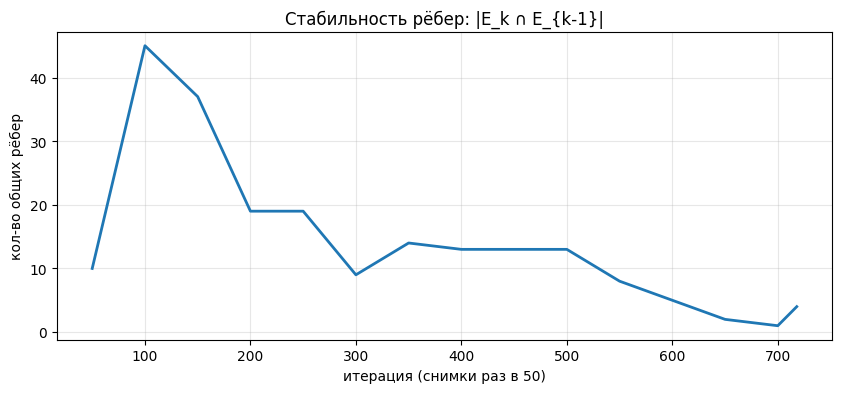

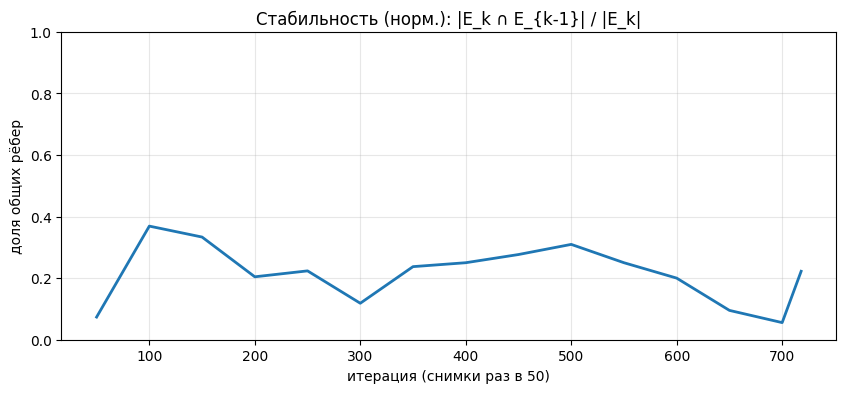

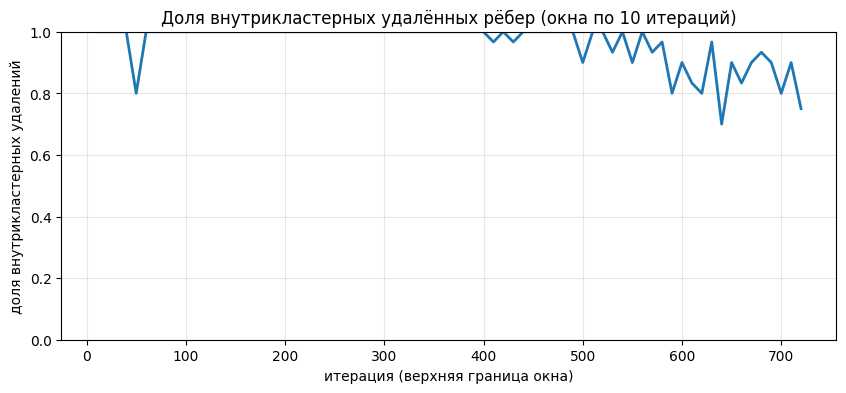

 метрика  initial  final
   edges      149     18
median_w       20      1
  mean_w       20      1
   sum_w     2967     18


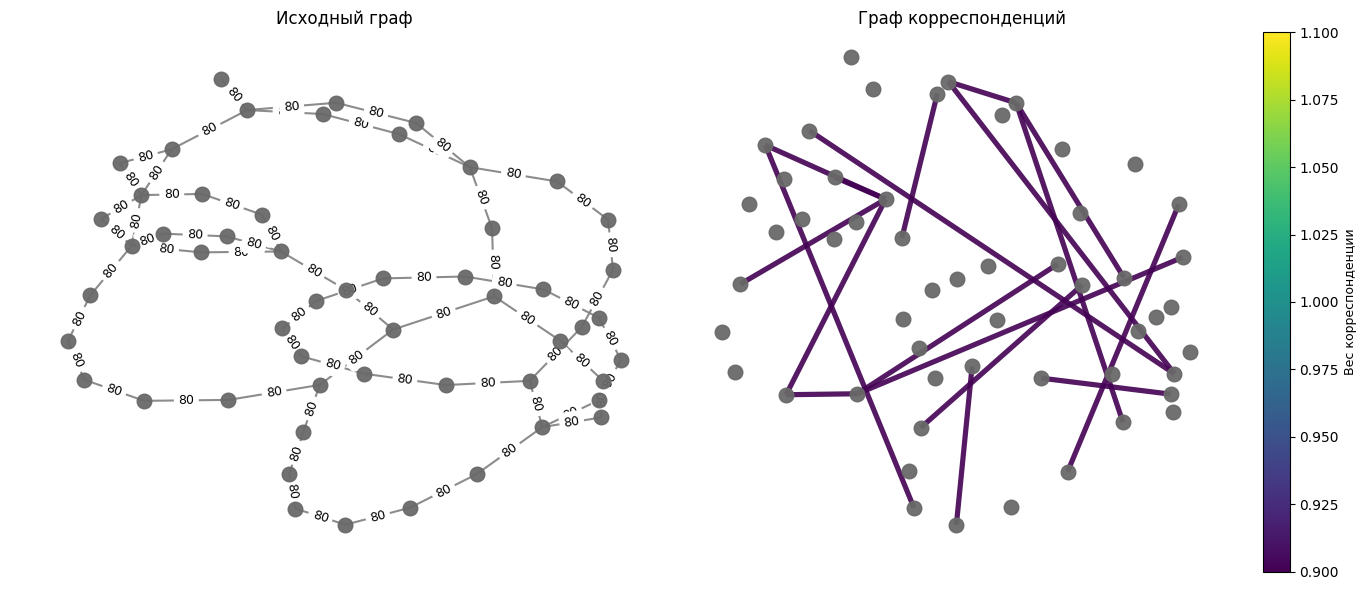

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 6.50 c
Итераций: 691 (доля от максимума 5400 = 12.80%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.3369, final_alpha=0.4784, converged=True
Плохие шаги всего: 337 (доля 0.49)
  — adversarial-плохих: 337 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


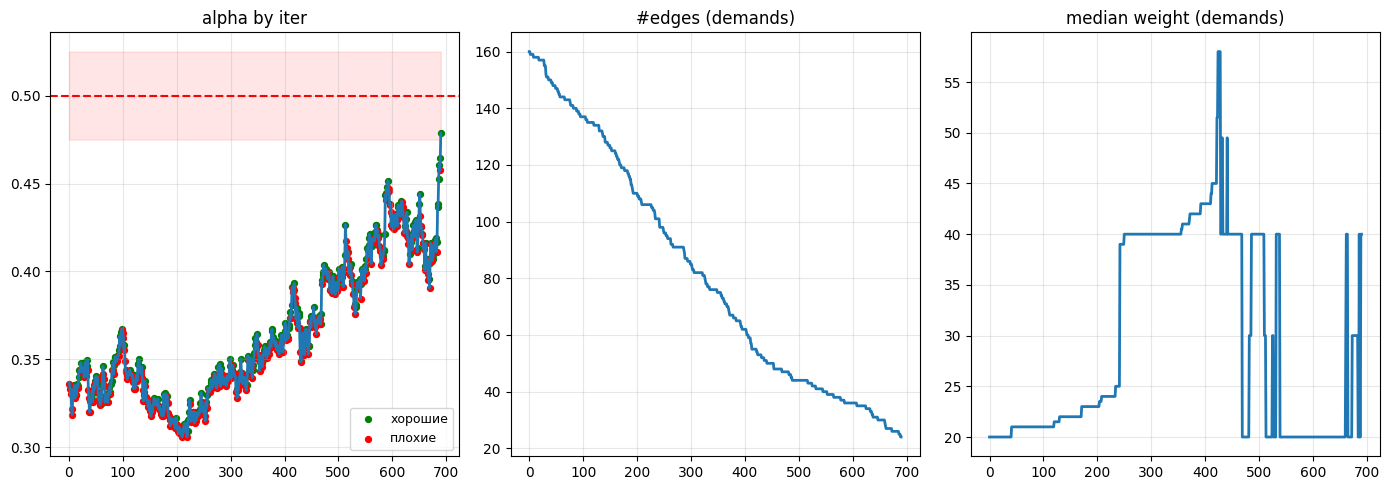

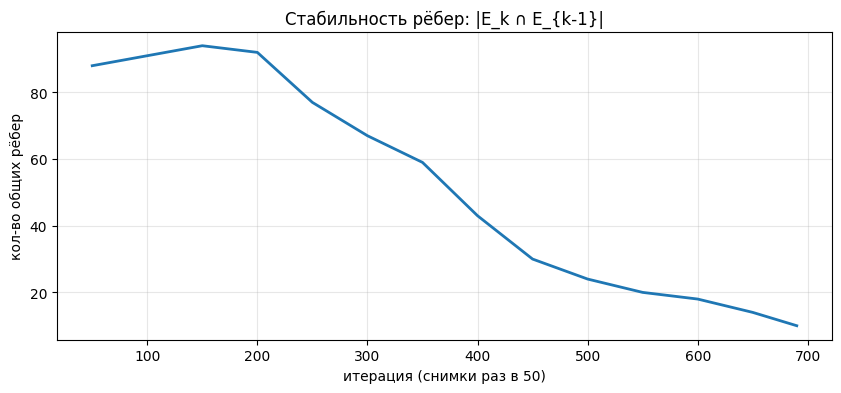

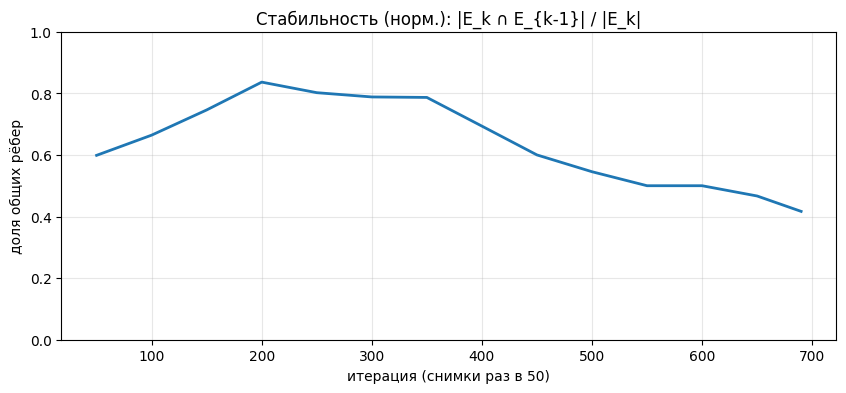

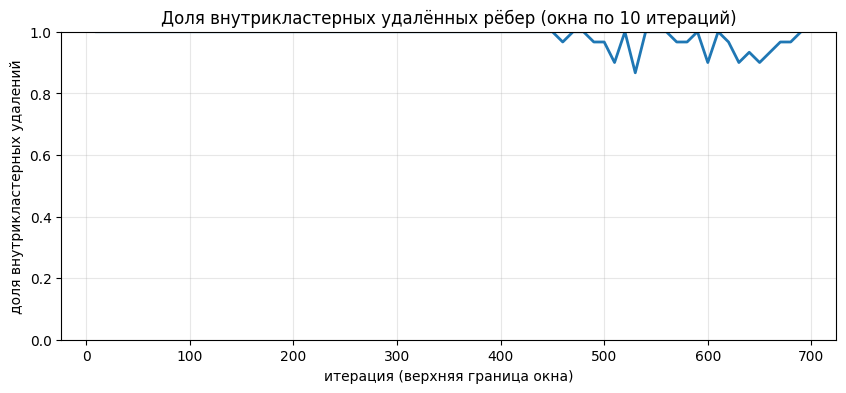

 метрика  initial  final
   edges      160     24
median_w       20     40
  mean_w       20     49
   sum_w     3207   1185


=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 3.93 c
Итераций: 1207 (доля от максимума 5400 = 22.35%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.3181, final_alpha=0.7583, converged=True
Плохие шаги всего: 590 (доля 0.49)
  — adversarial-плохих: 590 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


 метрика  initial  final
   edges      132      2
median_w       20     10
  mean_w       20     10
   sum_w     2630     19


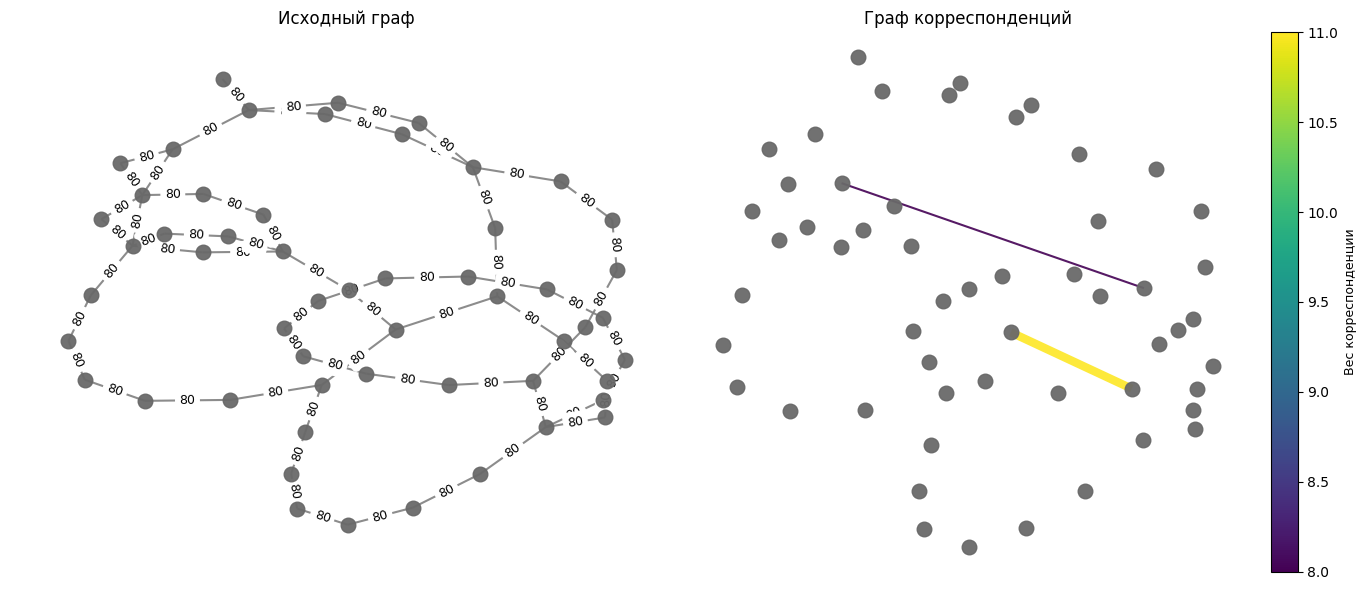



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 26.667 alpha_target=0.5: 0.235 alpha_target=0.75: 12.632
Средняя загруженность ребер: alpha_target=0.25: 0.004 alpha_target=0.5: 0.235 alpha_target=0.75: 0.004


=================================== Конец анализа работы алгоритма для cola_t8 ===================================


====================================   Анализ работы алгоритма для cola_t2  ====================================
=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.08 c
Итераций: 30 (доля от максимума 3200 = 0.94%)
alpha_target=0.25, epsilon=0.025
initial_alpha=0.1758, final_alpha=0.2318, converged=True
Плохие шаги всего: 9 (доля 0.31)
  — adversarial-плохих: 9 (доля 0.31)
  — friendly-плохих:   0 (доля 0.00)


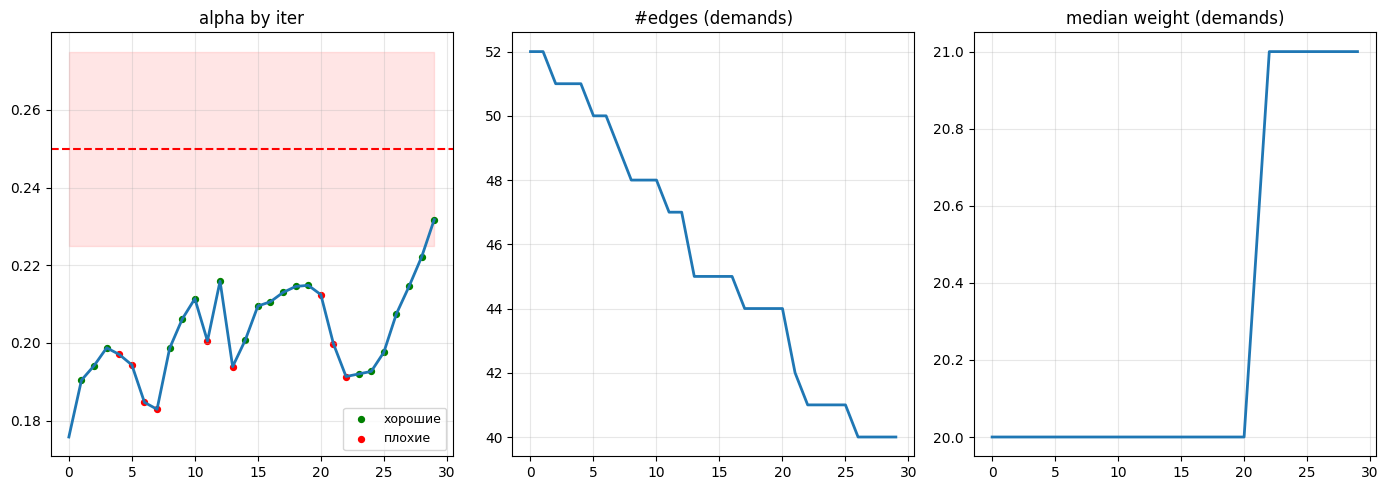

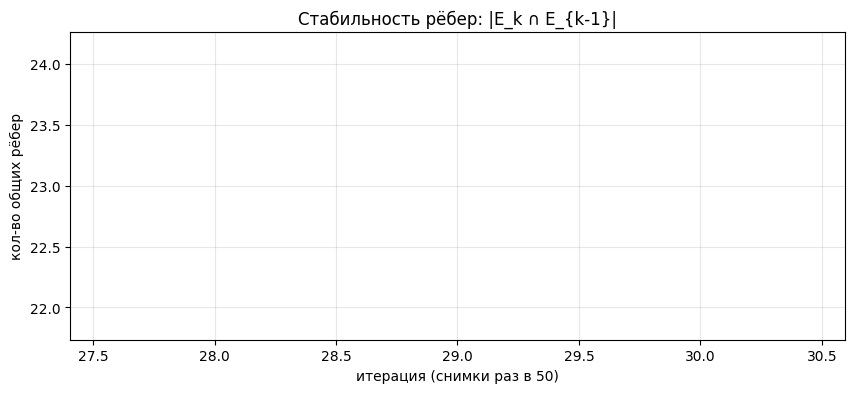

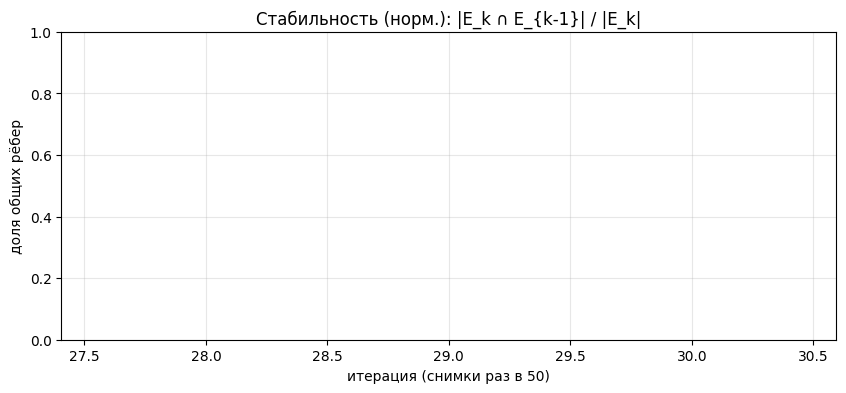

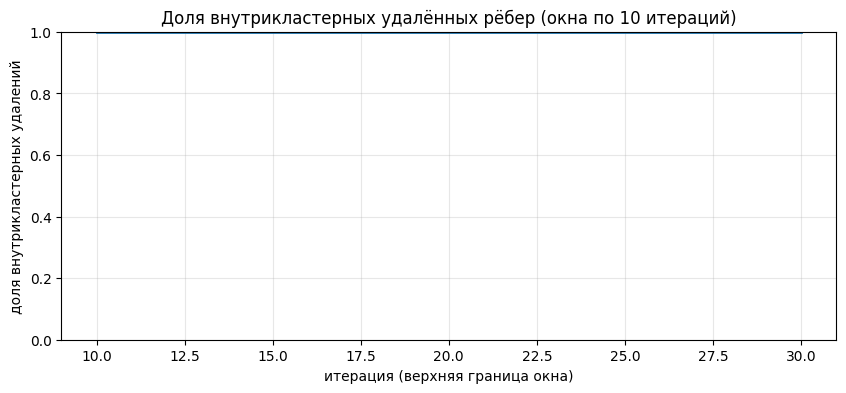

 метрика  initial  final
   edges       52     40
median_w       20     21
  mean_w       20     27
   sum_w     1040   1076


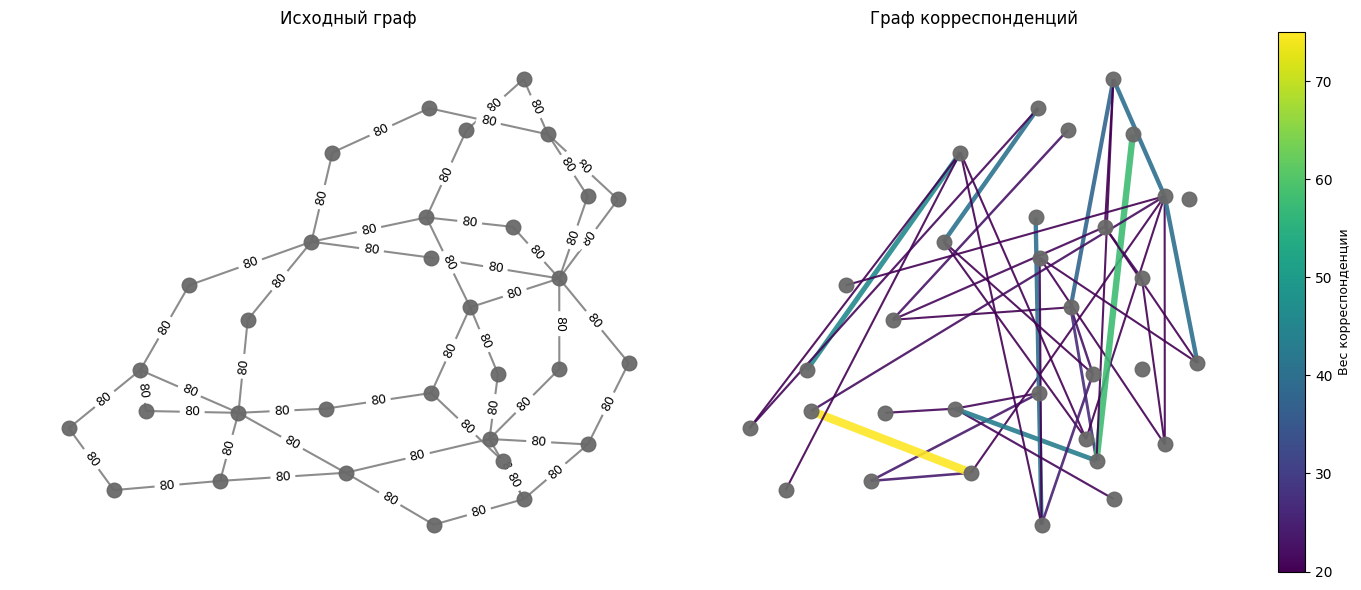

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.48 c
Итераций: 138 (доля от максимума 3200 = 4.31%)
alpha_target=0.5, epsilon=0.025
initial_alpha=0.2160, final_alpha=0.4823, converged=True
Плохие шаги всего: 61 (доля 0.45)
  — adversarial-плохих: 61 (доля 0.45)
  — friendly-плохих:   0 (доля 0.00)


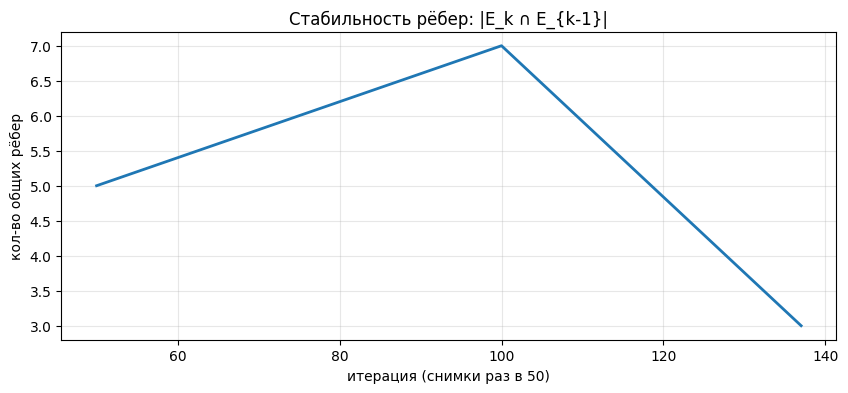

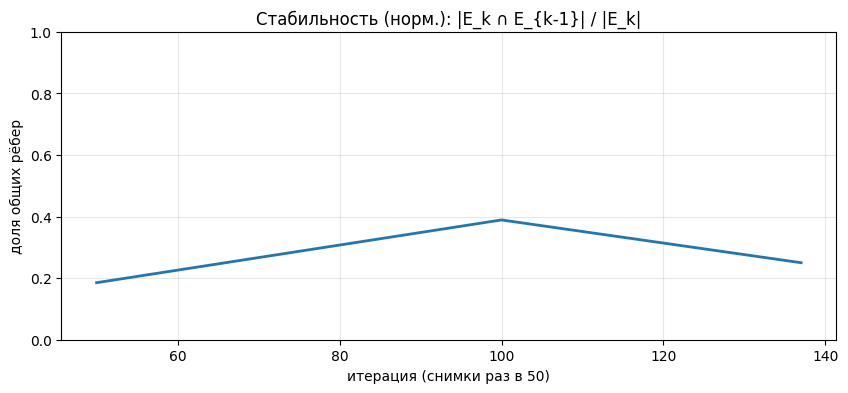

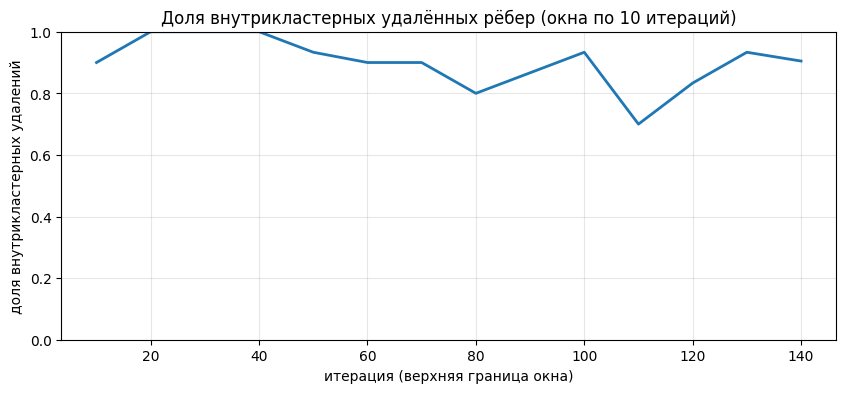

 метрика  initial  final
   edges       45     12
median_w       20     20
  mean_w       20     30
   sum_w      901    360


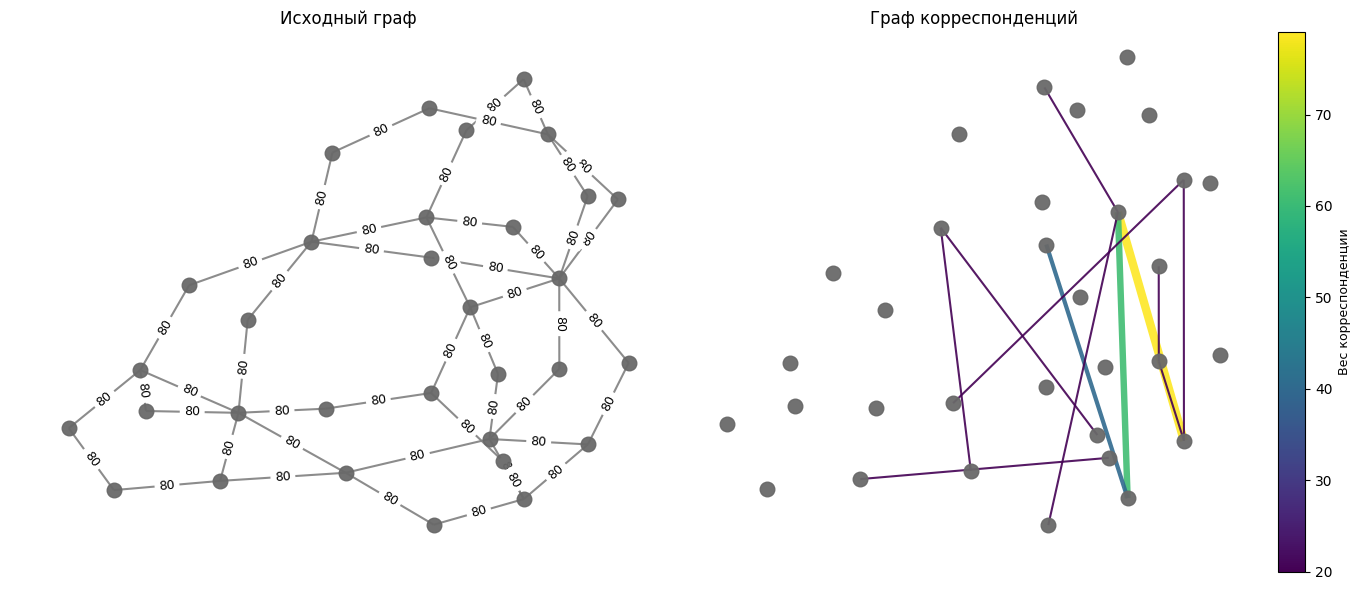

=== АНАЛИЗ (single run) ===
num_edges=3, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 0.87 c
Итераций: 334 (доля от максимума 3200 = 10.44%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.1883, final_alpha=0.7353, converged=True
Плохие шаги всего: 163 (доля 0.49)
  — adversarial-плохих: 163 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


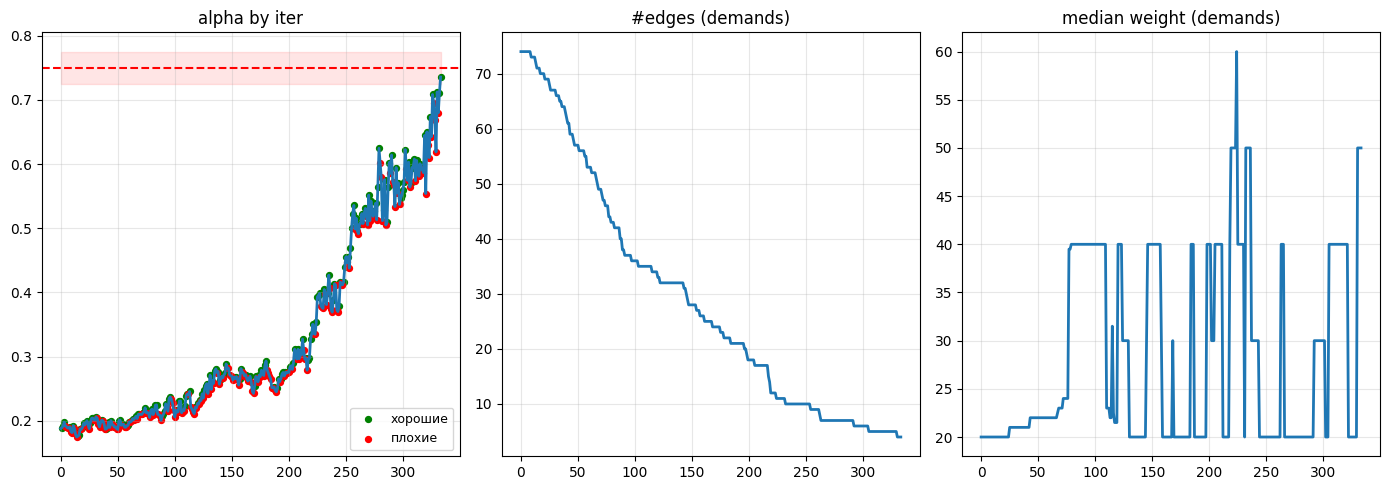

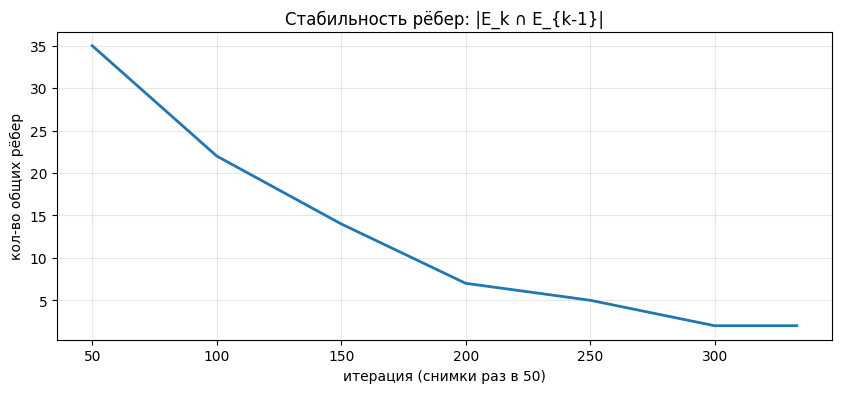

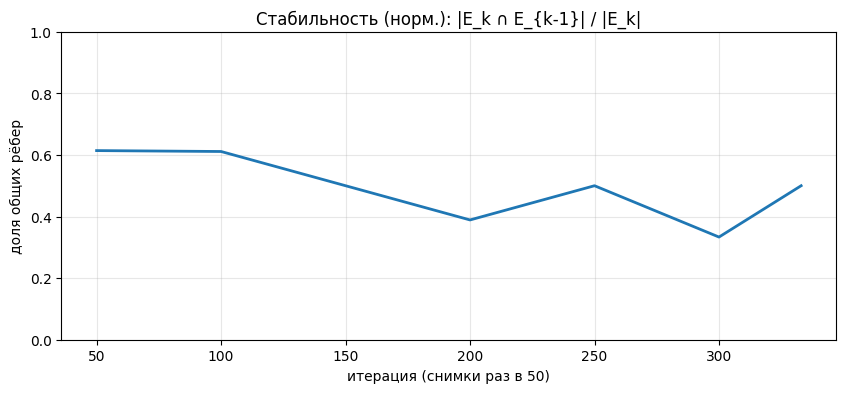

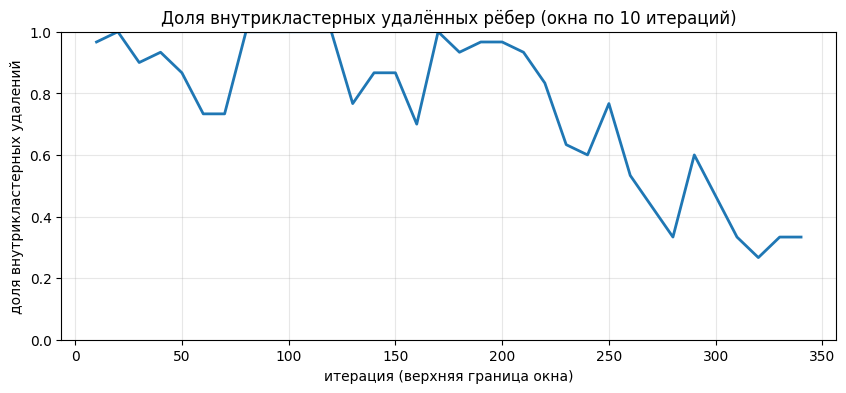

 метрика  initial  final
   edges       74      4
median_w       20     50
  mean_w       20     55
   sum_w     1493    220


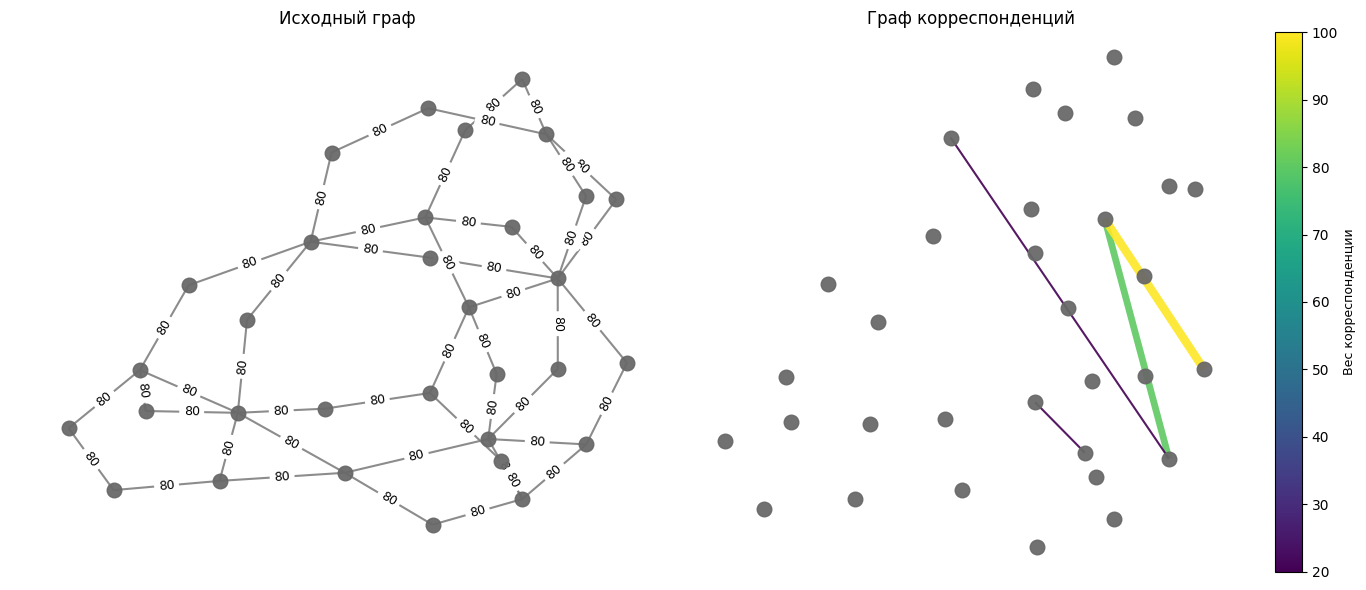



Решение MCF на итоге:
Значения gamma: alpha_target=0.25: 0.654 alpha_target=0.5: 0.889 alpha_target=0.75: 0.889
Средняя загруженность ребер: alpha_target=0.25: 0.286 alpha_target=0.5: 0.096 alpha_target=0.75: 0.059


=================================== Конец анализа работы алгоритма для cola_t2 ===================================




In [6]:
import numpy as np
from graphmcf import GraphMCF
from graphmcf.demands import MCFGeneratorMultiEdges
from graphmcf.analysis import analyze_simple

alphas_batch = [0.25, 0.5, 0.75] # должна быть хорошая, средняя, плохая проходимость, gamma убывает

for name, graph in small_graphs_for_test.items():
  alphas_gamma = []
  alphas_workload = [] # считаем среднюю нагруженность ребер как sum(веса ребер self.demands_graph) / sum(веса ребер self.graph), так как capacity одинаковая на графах
  print(f"====================================   Анализ работы алгоритма для {name}  ====================================")

  for alpha_target in alphas_batch:
    graph_for_mcf = GraphMCF(graph['adj_matrix'])
    gen = MCFGeneratorMultiEdges(epsilon=0.025,
                                 p_ER = 0.10, distribution="normal", median_weight_for_initial=20, var_for_initial=5,
                                 demands_median_denominator=8, demands_var_denominator=16,
                                 num_edges=None, p_for_delete_edge=1.0, p_for_upsert_edge=1.0,)
    res = gen.generate(graph=graph_for_mcf, alpha_target=alpha_target)
    analyze_simple(graph_for_mcf, alpha_target=alpha_target, epsilon=0.025,
                   start_time=res.start_time, end_time=res.end_time,
                   alpha_history=res.alpha_history,
                   edge_counts_history=res.edge_counts_history,
                   median_weights_history=res.median_weights_history,
                   edge_mask_history=res.edge_mask_history,
                   edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
                   removal_events=res.removal_events,
                   algo_params=res.algo_params)
    graph_for_mcf.visualise_with_demands()

    sol = solve_throughput(graph_for_mcf.graph, graph_for_mcf.demands_laplacian)
    gamma = sol.gamma
    alphas_gamma.append(f"alpha_target={alpha_target}: {gamma:.3f}")

    demands_sum = sum(data['weight'] for u, v, data in graph_for_mcf.demands_graph.edges(data=True))
    capacity_sum = sum(data['weight'] for u, v, data in graph_for_mcf.graph.edges(data=True))
    workload = demands_sum / capacity_sum
    alphas_workload.append(f"alpha_target={alpha_target}: {workload:.3f}")

  gamma_sequence = " ".join(alphas_gamma)
  workload_sequence = " ".join(alphas_workload)
  print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\nСредняя загруженность ребер: {workload_sequence}\n\n")
  print(f"=================================== Конец анализа работы алгоритма для {name} ===================================\n\n")

Протестируем на среднем графе cola_t7 (162 вершины)

In [7]:
med_graph_for_test_name = 'cola_t7'
med_graph_for_test = get_graphs(path_to_folder, med_graph_for_test_name, True)[med_graph_for_test_name]

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 1.85 c
Итераций: 99 (доля от максимума 16200 = 0.61%)
alpha_target=0.15, epsilon=0.025
initial_alpha=0.1783, final_alpha=0.1733, converged=True
Плохие шаги всего: 49 (доля 0.50)
  — adversarial-плохих: 0 (доля 0.00)
  — friendly-плохих:   49 (доля 0.50)


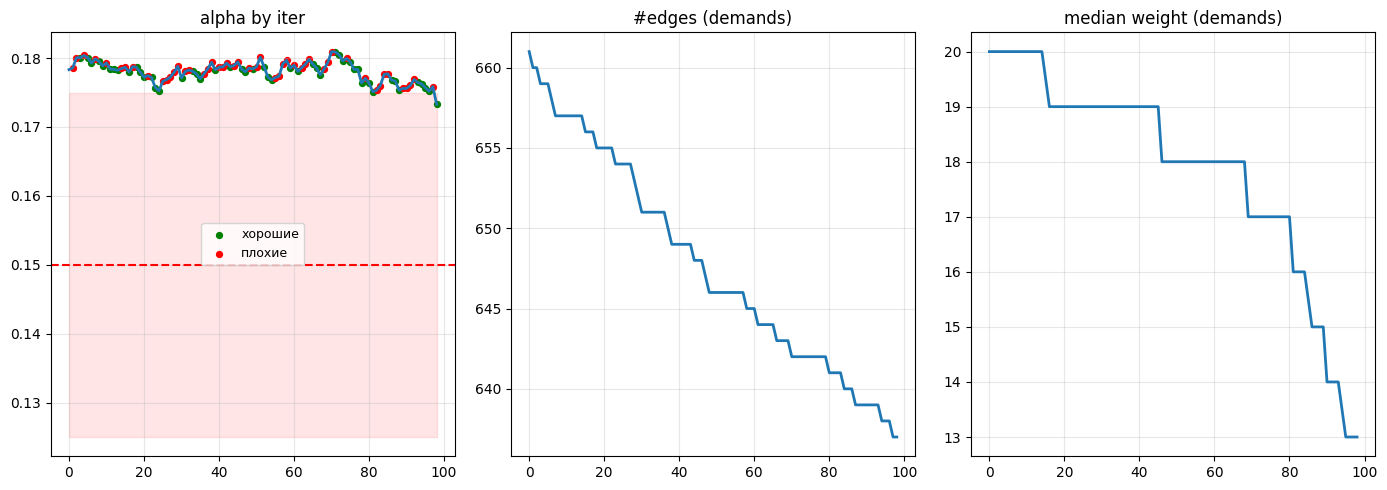

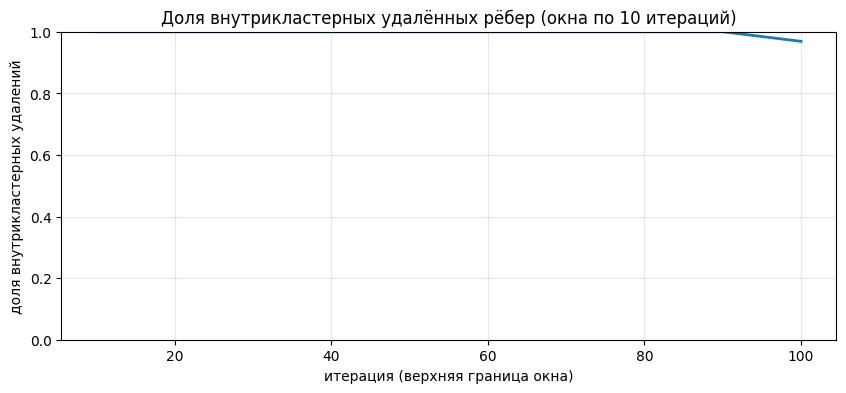

 метрика  initial  final
   edges      661    637
median_w       20     13
  mean_w       20     14
   sum_w    13249   8679


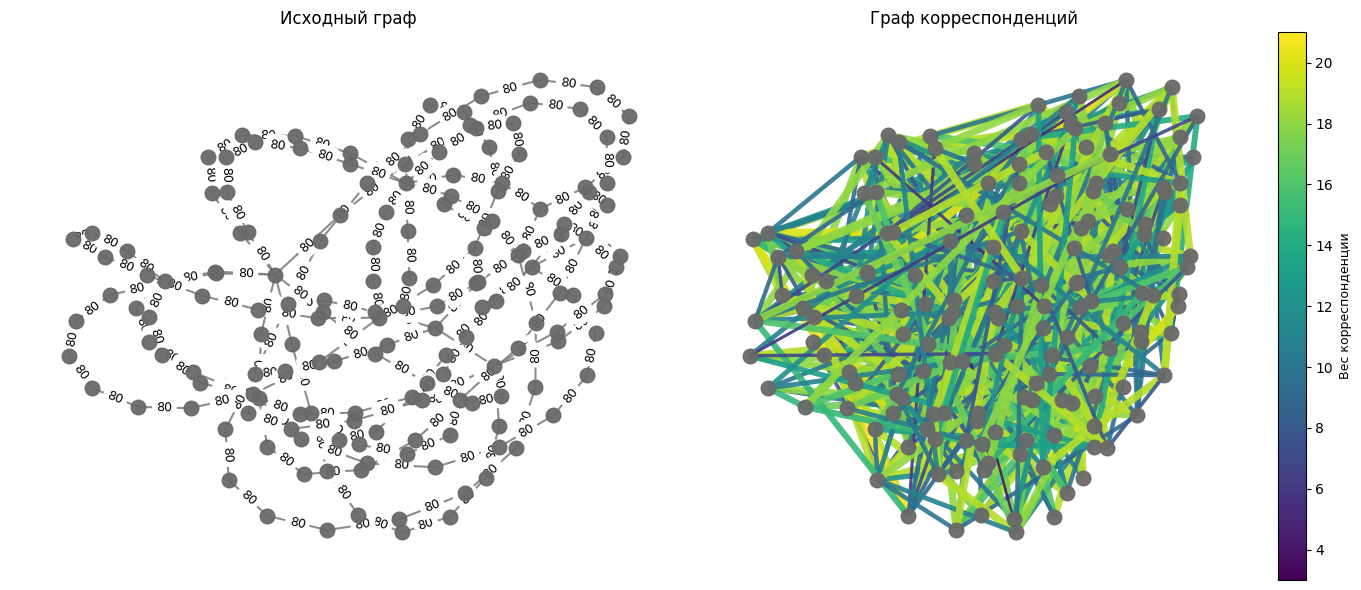

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 71.00 c
Итераций: 7085 (доля от максимума 16200 = 43.73%)
alpha_target=0.35, epsilon=0.025
initial_alpha=0.1795, final_alpha=0.3283, converged=True
Плохие шаги всего: 3503 (доля 0.49)
  — adversarial-плохих: 3503 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


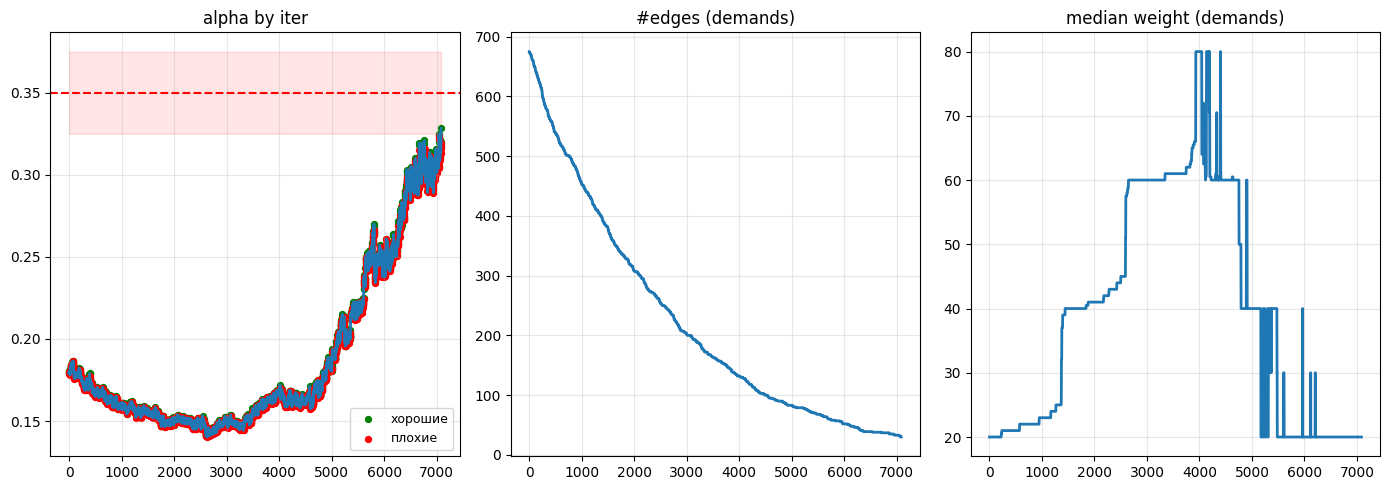

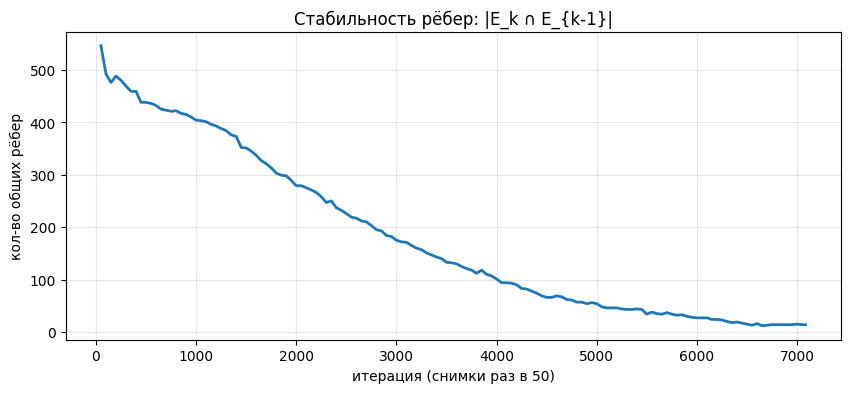

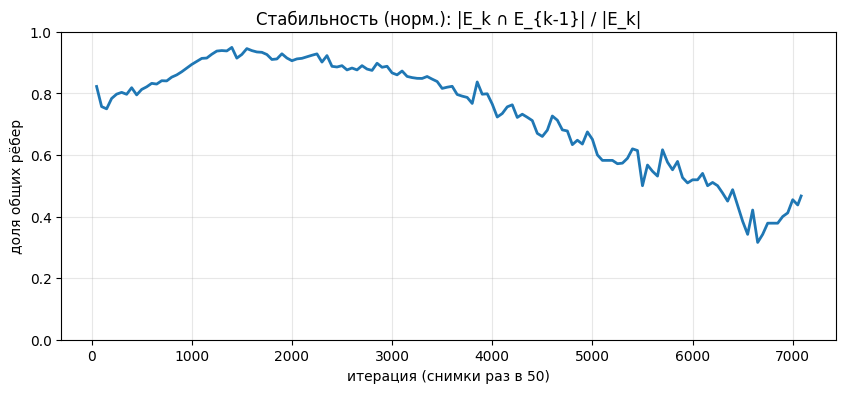

 метрика  initial  final
   edges      675     30
median_w       20     20
  mean_w       20     53
   sum_w    13438   1580


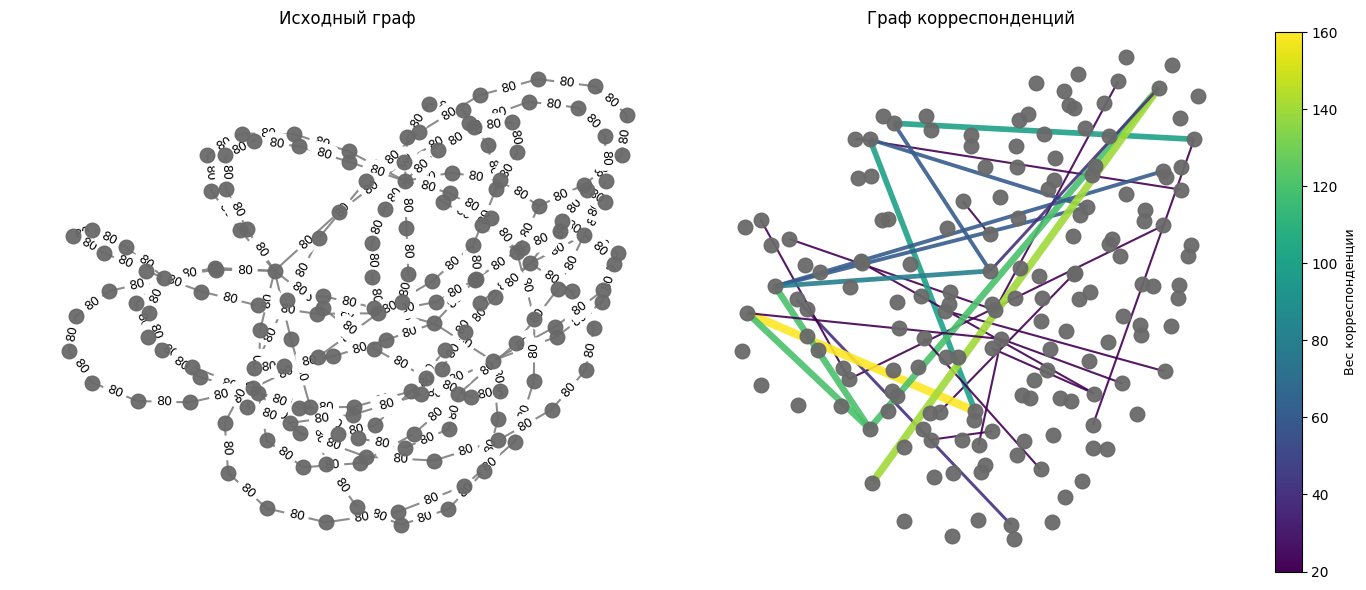

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 85.36 c
Итераций: 8813 (доля от максимума 16200 = 54.40%)
alpha_target=0.55, epsilon=0.025
initial_alpha=0.1776, final_alpha=0.5327, converged=True
Плохие шаги всего: 4348 (доля 0.49)
  — adversarial-плохих: 4348 (доля 0.49)
  — friendly-плохих:   0 (доля 0.00)


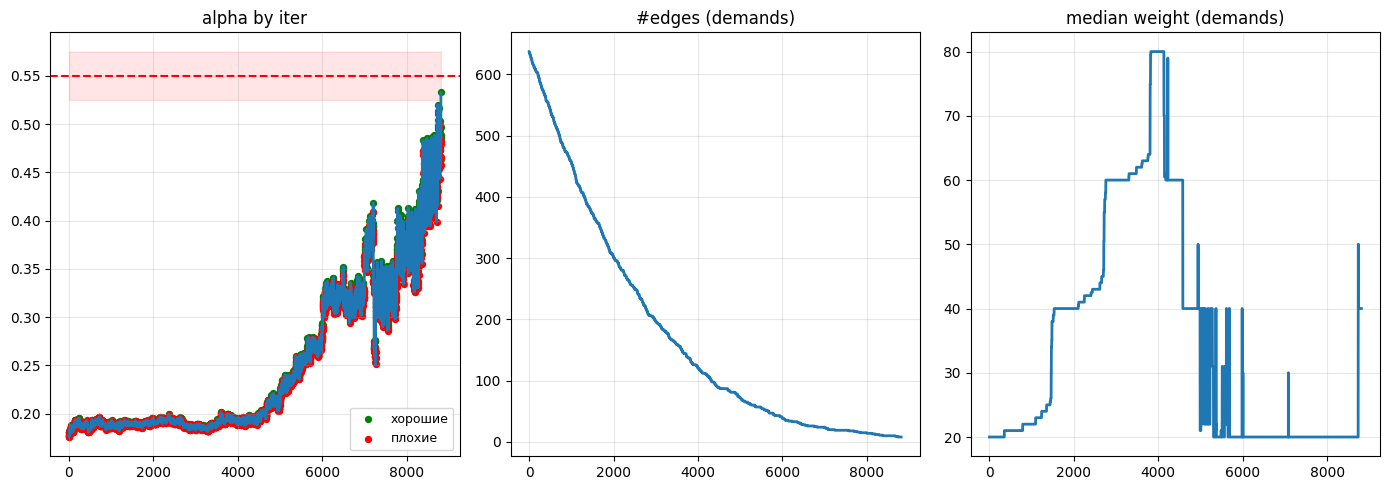

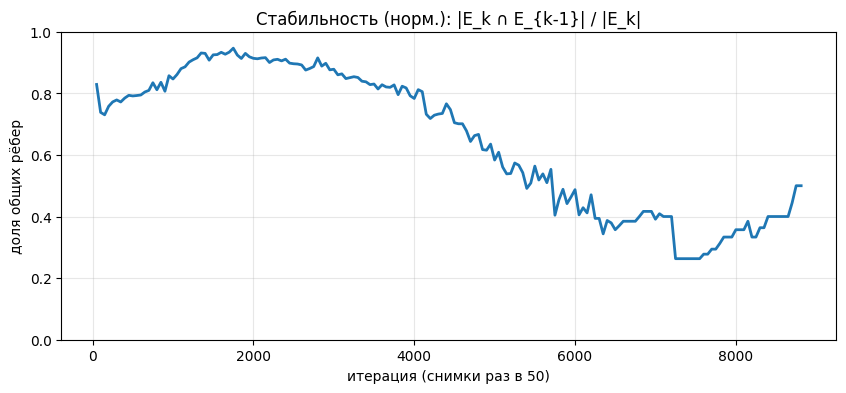

 метрика  initial  final
   edges      637      8
median_w       20     40
  mean_w       20     43
   sum_w    12656    342


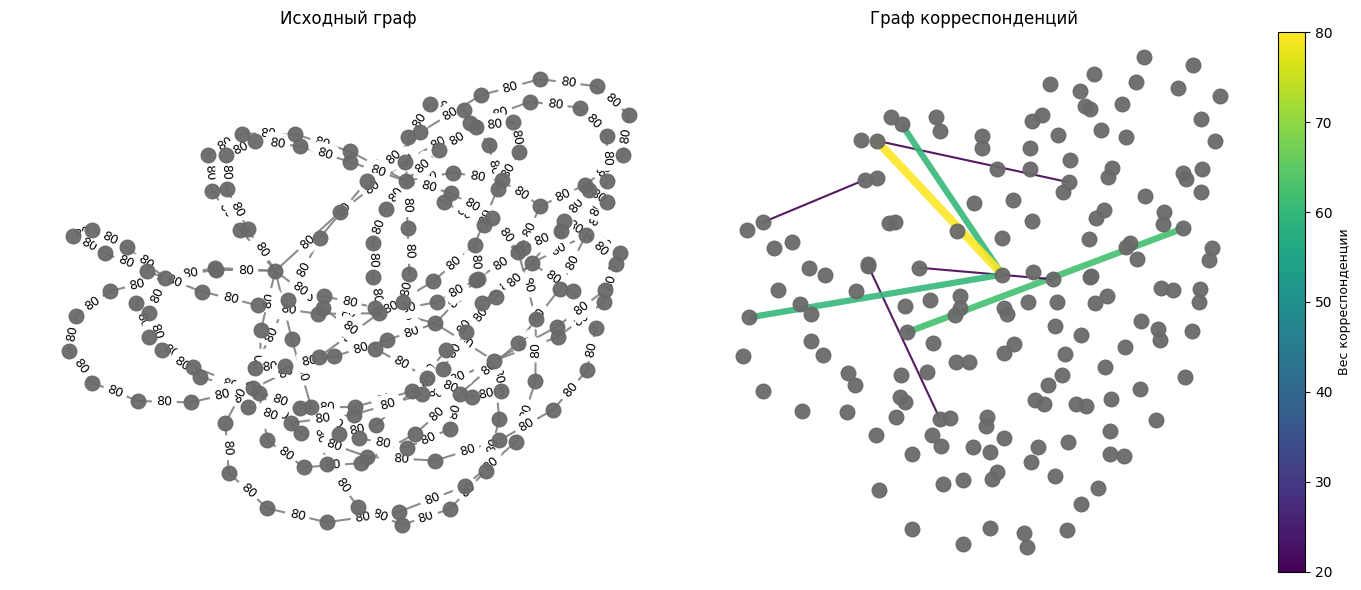

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 122.34 c
Итераций: 12368 (доля от максимума 16200 = 76.35%)
alpha_target=0.75, epsilon=0.025
initial_alpha=0.1733, final_alpha=0.7256, converged=True
Плохие шаги всего: 6147 (доля 0.50)
  — adversarial-плохих: 6147 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


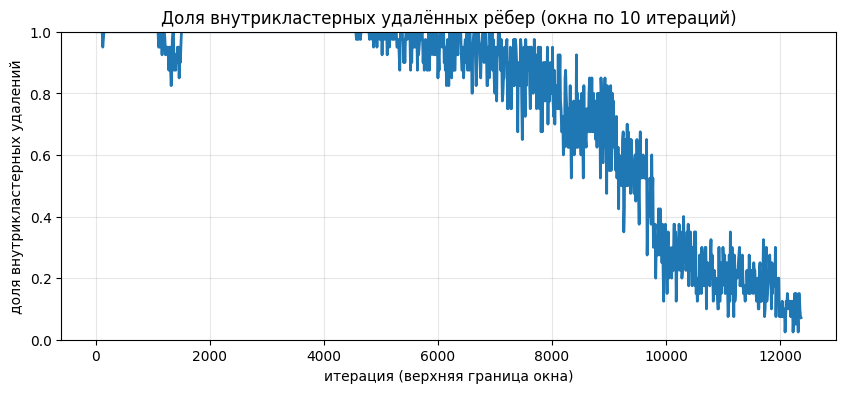

 метрика  initial  final
   edges      668      3
median_w       20    120
  mean_w       20     93
   sum_w    13290    280


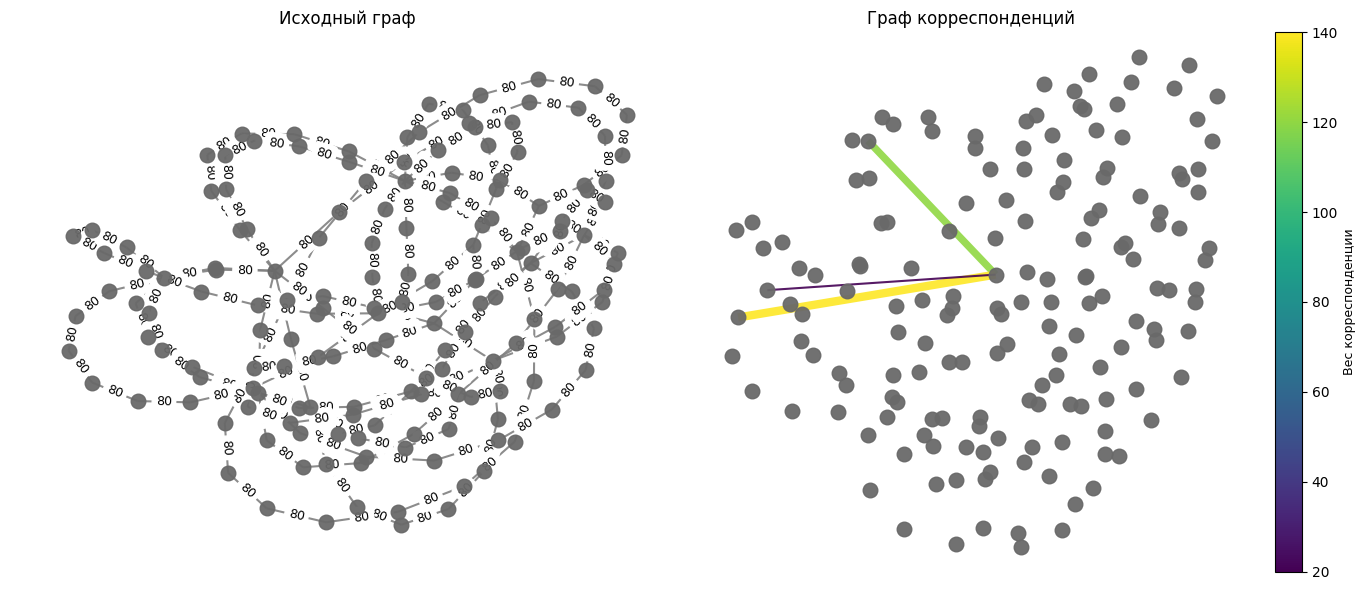

=== АНАЛИЗ (single run) ===
num_edges=4, p_for_delete_edge=1.0, p_for_upsert_edge=1.0
Время выполнения: 109.67 c
Итераций: 11598 (доля от максимума 16200 = 71.59%)
alpha_target=0.95, epsilon=0.025
initial_alpha=0.1917, final_alpha=0.9280, converged=True
Плохие шаги всего: 5742 (доля 0.50)
  — adversarial-плохих: 5742 (доля 0.50)
  — friendly-плохих:   0 (доля 0.00)


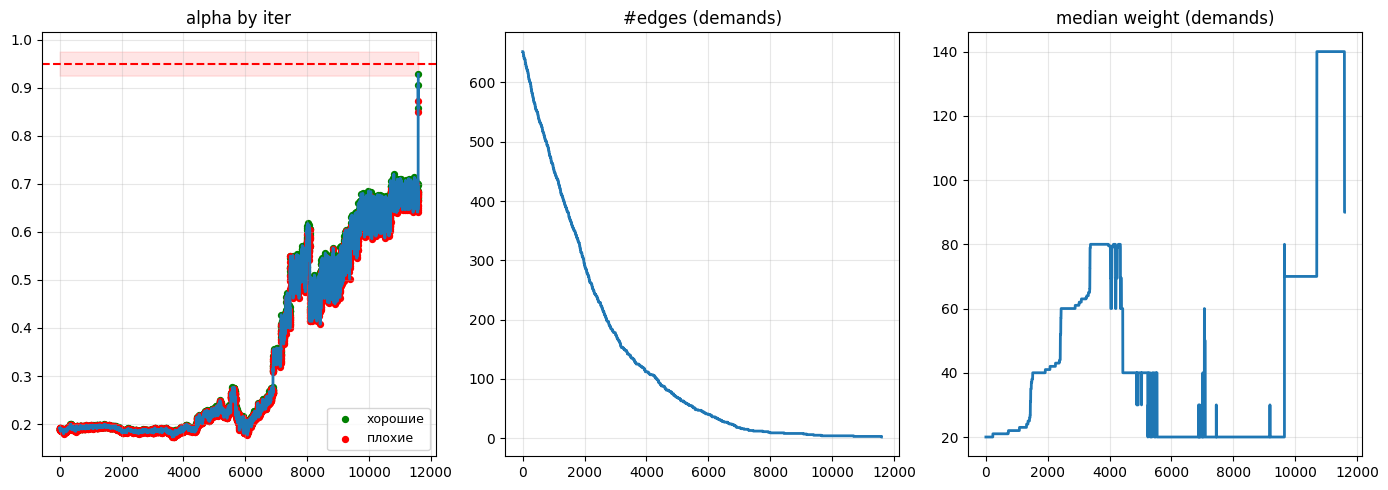

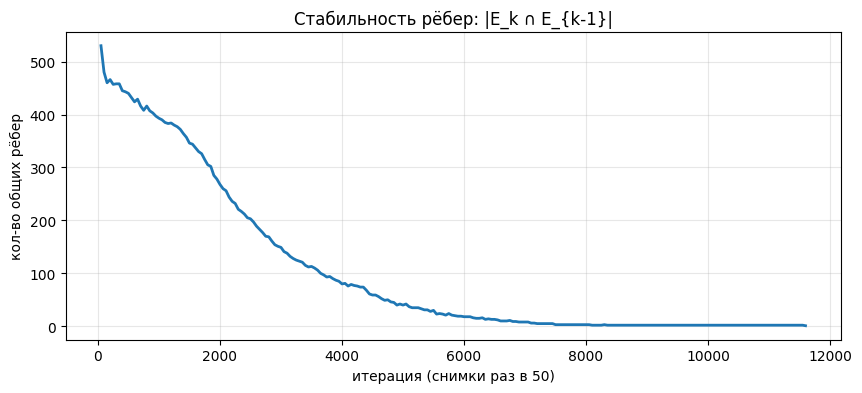

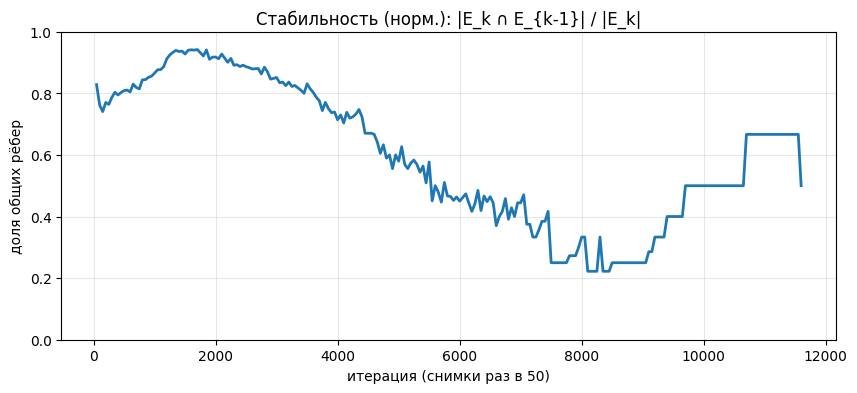

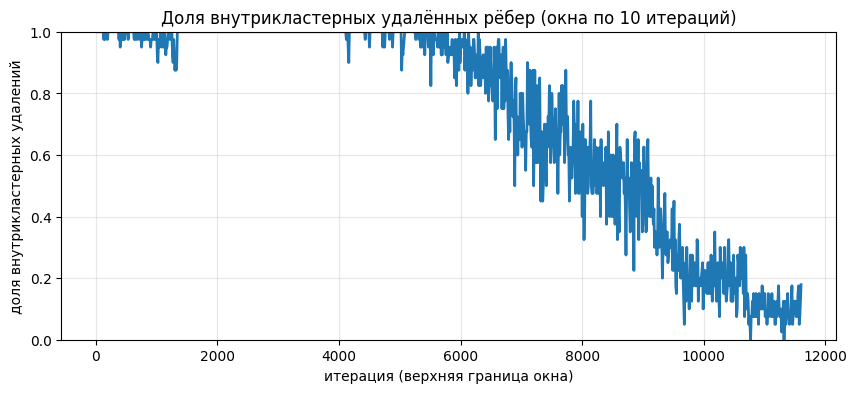

 метрика  initial  final
   edges      652      2
median_w       20     90
  mean_w       20     90
   sum_w    12992    180


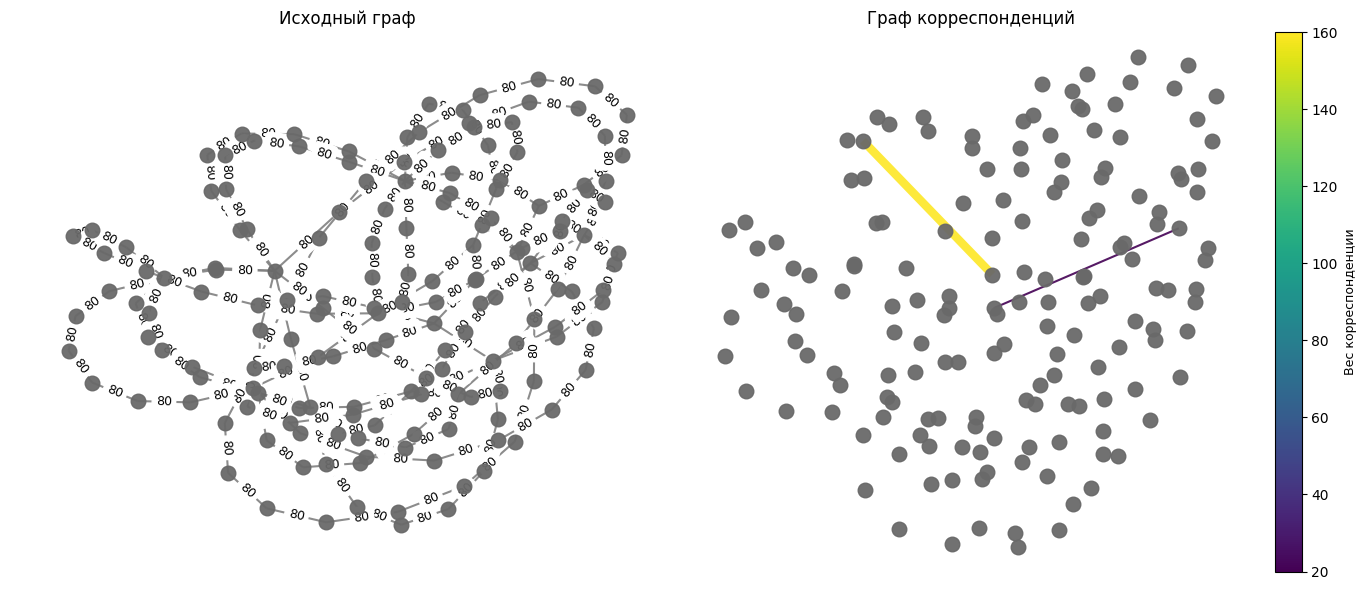



Решение MCF на итоге:
Значения gamma: alpha_target=0.15: 0.10540184452870892 alpha_target=0.35: 0.2580645154624658 alpha_target=0.55: 0.7999999999948931 alpha_target=0.75: 0.5714285713379837 alpha_target=0.95: 0.9999999999825603
Средняя загруженность ребер: alpha_target=0.15: 0.568 alpha_target=0.35: 0.103 alpha_target=0.55: 0.022 alpha_target=0.75: 0.018 alpha_target=0.95: 0.012




In [8]:
alphas_batch = [0.15, 0.35, 0.55, 0.75, 0.95]

alphas_gamma = []
alphas_workload = [] # считаем среднюю нагруженность ребер как sum(веса ребер self.demands_graph) / sum(веса ребер self.graph), так как capacity одинаковая на графах
for alpha_target in alphas_batch:
  graph_for_mcf = GraphMCF(med_graph_for_test['adj_matrix'])
  gen = MCFGeneratorMultiEdges(epsilon=0.025,
                               p_ER = 0.05, distribution="normal", median_weight_for_initial=20, var_for_initial=5,
                               demands_median_denominator=8, demands_var_denominator=16,
                               num_edges=None, p_for_delete_edge=1.0, p_for_upsert_edge=1.0,)
  res = gen.generate(graph=graph_for_mcf, alpha_target=alpha_target)
  analyze_simple(graph_for_mcf, alpha_target=alpha_target, epsilon=0.025,
                 start_time=res.start_time, end_time=res.end_time,
                 alpha_history=res.alpha_history,
                 edge_counts_history=res.edge_counts_history,
                 median_weights_history=res.median_weights_history,
                 edge_mask_history=res.edge_mask_history,
                 edge_mask_snapshot_iters=res.edge_mask_snapshot_iters,
                 removal_events=res.removal_events,
                 algo_params=res.algo_params)
  graph_for_mcf.visualise_with_demands()

  sol = solve_throughput(graph_for_mcf.graph, graph_for_mcf.demands_laplacian)
  gamma = sol.gamma
  alphas_gamma.append(f"alpha_target={alpha_target}: {gamma}")

  demands_sum = sum(data['weight'] for u, v, data in graph_for_mcf.demands_graph.edges(data=True))
  capacity_sum = sum(data['weight'] for u, v, data in graph_for_mcf.graph.edges(data=True))
  workload = demands_sum / capacity_sum
  alphas_workload.append(f"alpha_target={alpha_target}: {workload:.3f}")

gamma_sequence = " ".join(alphas_gamma)
workload_sequence = " ".join(alphas_workload)
print(f"\n\nРешение MCF на итоге:\nЗначения gamma: {gamma_sequence}\nСредняя загруженность ребер: {workload_sequence}\n\n")